# Truncated long-wavelength anomaly

This notebook investigates the effects of having truncated long-wavelength signals using the ICEGRAV synthetic. The data file needed was created in notebook 04_icegrav_datasets.ipynb.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import harmonica as hm
import verde as vd
import xarray as xr
import eqs_magnetics as eqs
import synthetics
from pathlib import Path
from IPython.display import Image
import warnings

In [2]:
# Suppress some scikit-learn warning that isn't valid
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## Load data

In [3]:
icegrav = pd.read_csv('../data/icegrav.csv',)
synthetic = icegrav[(icegrav['x'] >= 1.9e6) & (icegrav['y'] <= 3.1e6)]
synthetic.reset_index(inplace=True)
coordinates = [synthetic.x, synthetic.y, synthetic.Height_WGS1984]
field_direction = np.array([hm.magnetic_angles_to_vec(1, -65, 35)]).T
source_coordinates, dipole_moments = synthetics.truncated_regional_synthetic(
    source1=[75,60],
    source2=[-60,45],
    source3=[50,70],
    source4=[-70,40],
    dyke1=[-70,80],
    dyke2=[-70,80],
    dipoles=[45,-65],
    regional=[-50,40]   
)
b_synthetic = eqs.dipole_magnetic(coordinates, source_coordinates, dipole_moments)
tfa_synthetic = eqs.total_field_anomaly(b_synthetic, field_direction)
bnorm_synthetic = eqs.magnetic_field_norm(b_synthetic)

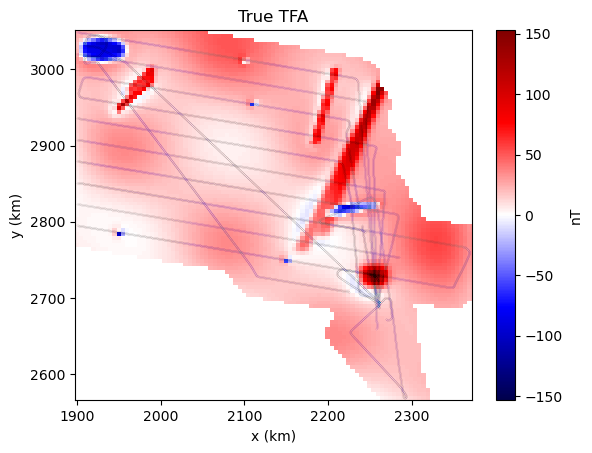

In [4]:
region = vd.get_region(coordinates)
grid_spacing = 5e3
grid_coordinates = vd.grid_coordinates(region, spacing=grid_spacing, extra_coords=3e3)
mask = vd.distance_mask(data_coordinates=coordinates, maxdist=28e3, coordinates=grid_coordinates)
grid_coords_masked = (
    np.array((xr.DataArray(grid_coordinates[0])).where(mask, drop=False)),
    np.array((xr.DataArray(grid_coordinates[1])).where(mask, drop=False)),
    np.array((xr.DataArray(grid_coordinates[2])).where(mask, drop=False))
)

coordinates_km = [coord / 1000 for coord in coordinates]
grid_coordinates_km = [coord / 1000 for coord in grid_coordinates]

true_b = eqs.dipole_magnetic(grid_coords_masked, source_coordinates, dipole_moments)
true_tfa = eqs.total_field_anomaly(true_b, field_direction)
true_bnorm = true_bnorm = np.sqrt(sum(c**2 for c in true_b))

plt.figure()
scale = vd.maxabs(true_tfa)
plt.pcolormesh(*grid_coordinates_km[:2], true_tfa, cmap="seismic", vmin=-scale, vmax=scale)
plt.plot(*coordinates_km[:2], '.', markersize=0.005)
plt.title("True TFA")
plt.xlabel("x (km)")
plt.ylabel("y (km)")
plt.colorbar(label="nT")
plt.show()

## Truncate the long-wavelength dipole
Apply the single and dual layer EQS approaches as the long-wavelength dipole is moved out of the survey bounds.

2900000.0


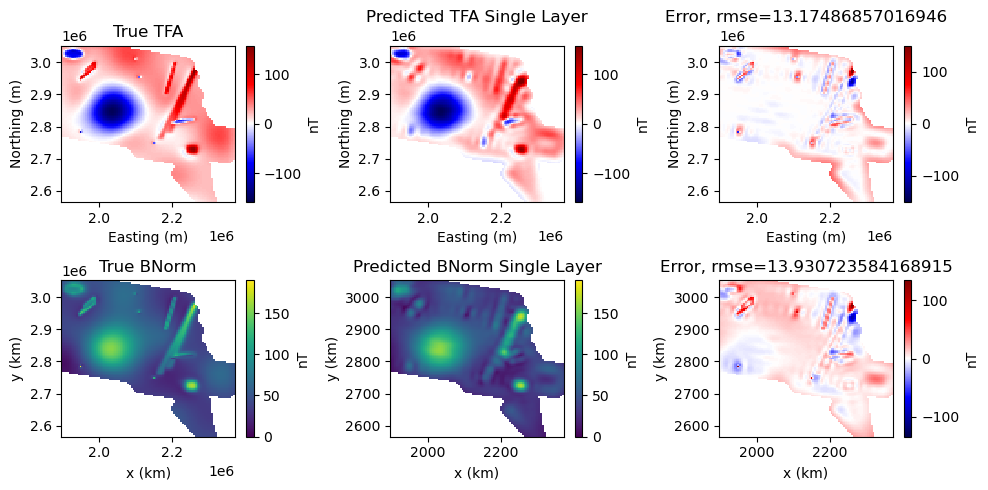

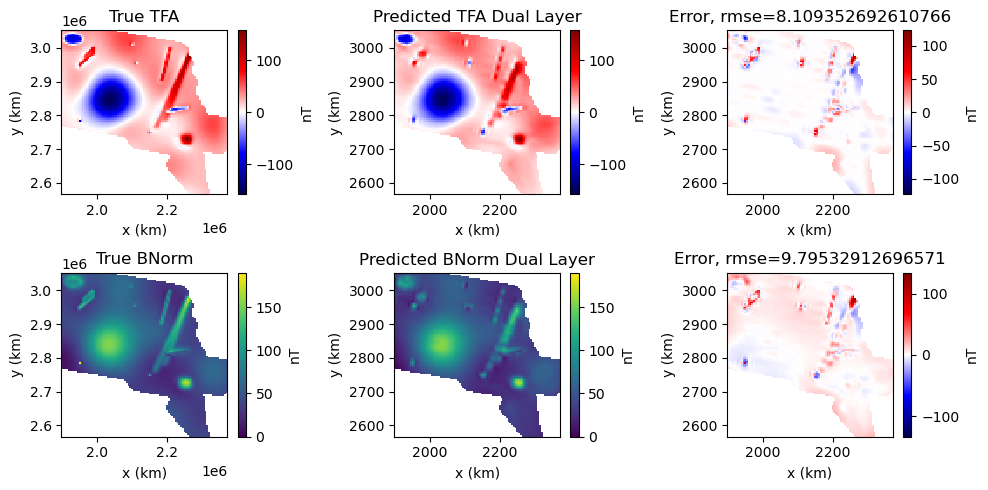

2890000.0


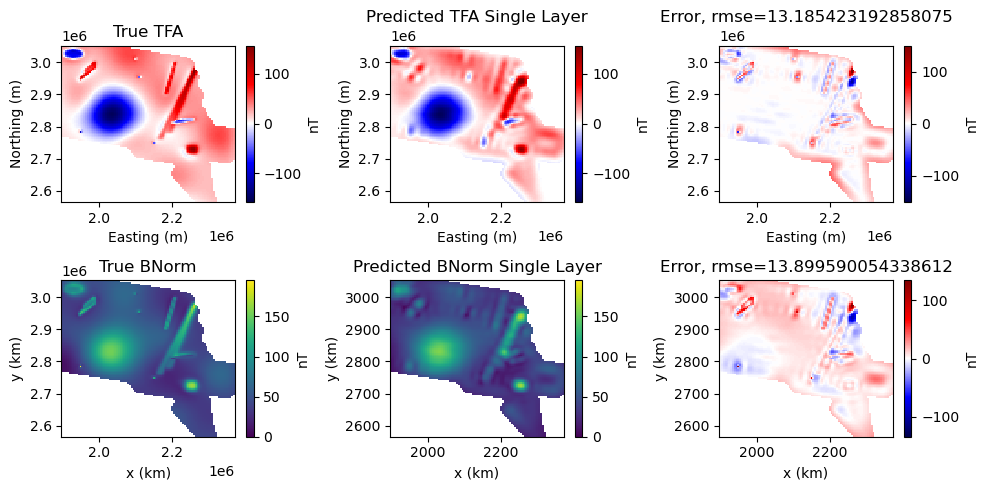

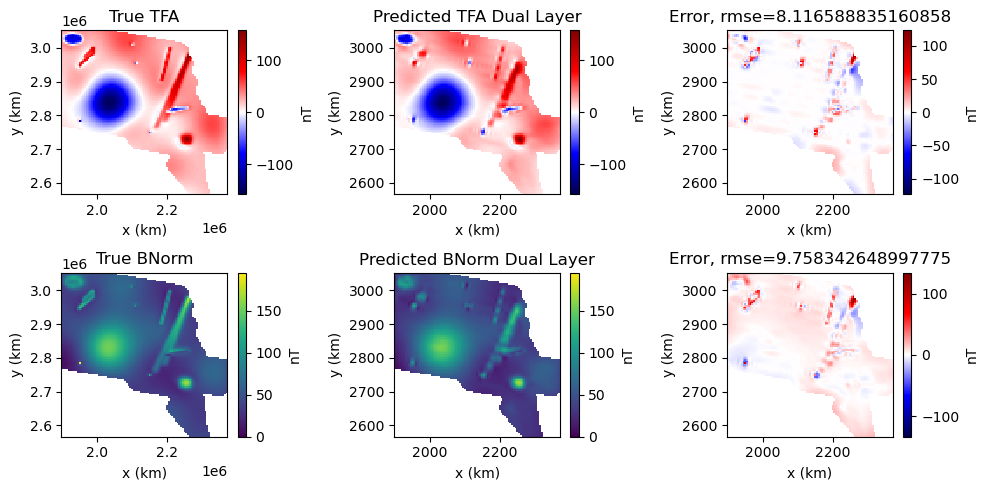

2880000.0


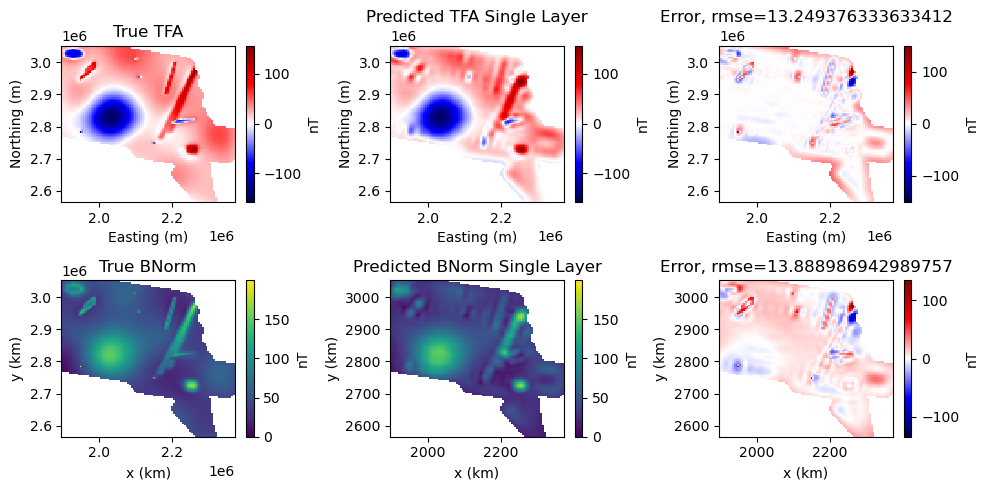

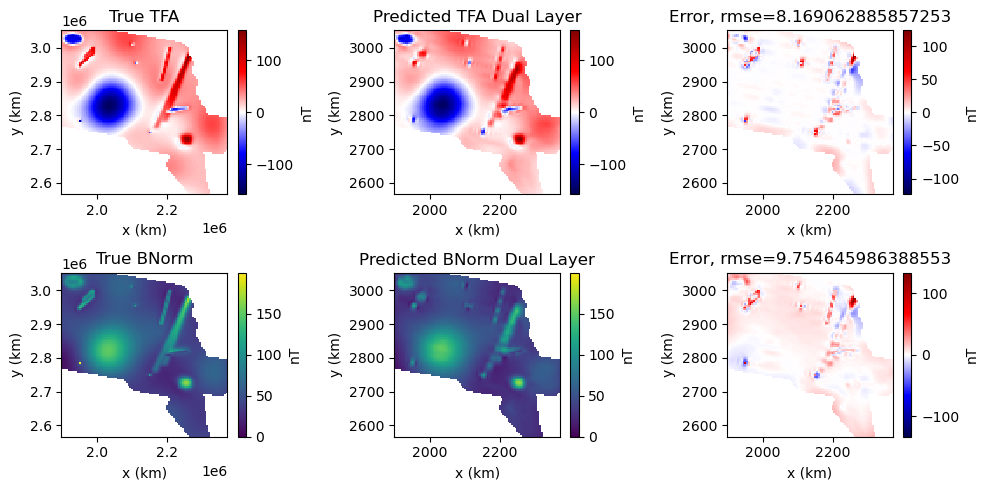

2870000.0


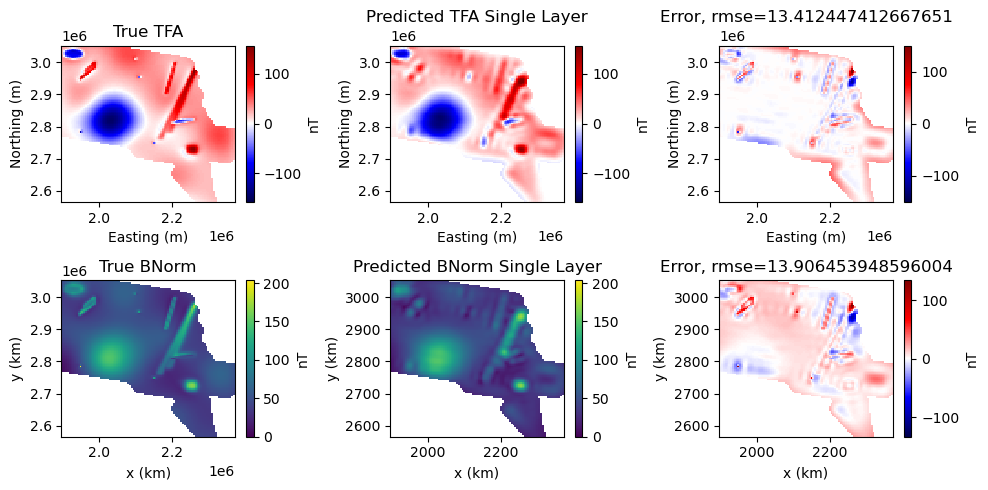

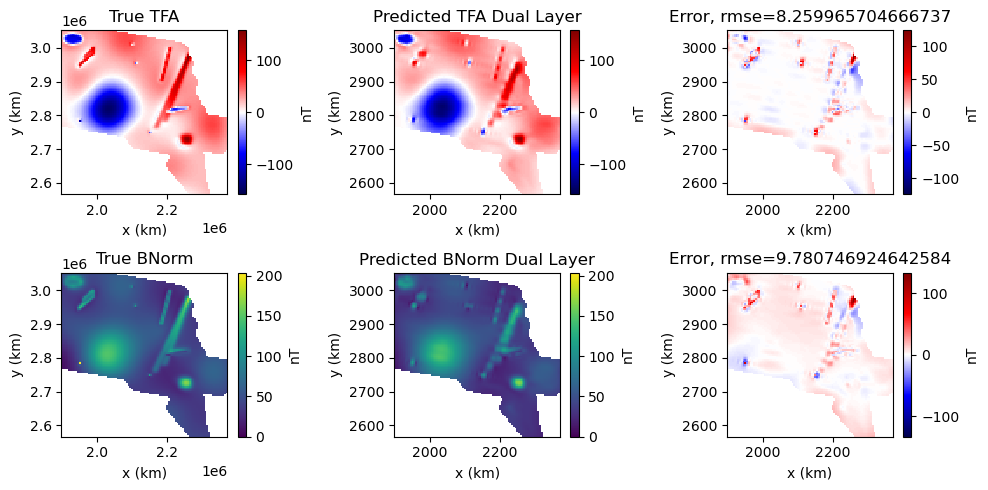

2860000.0


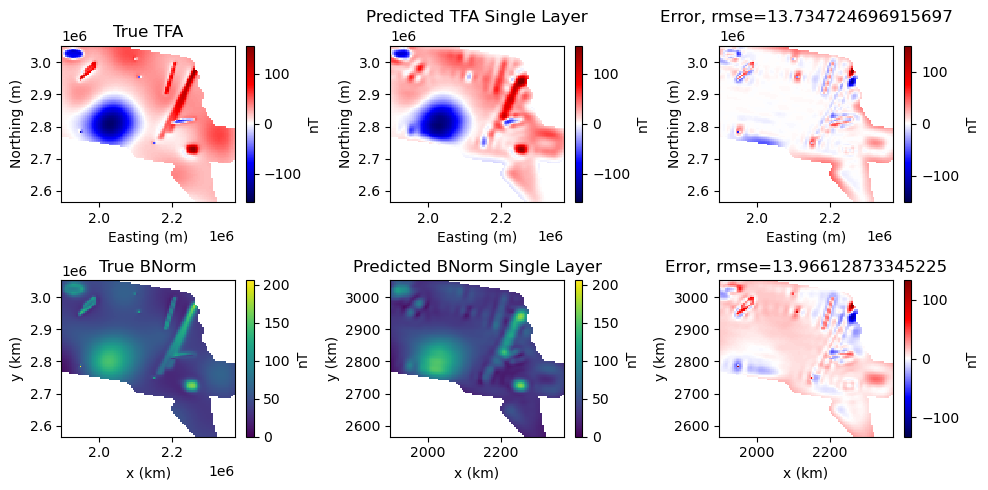

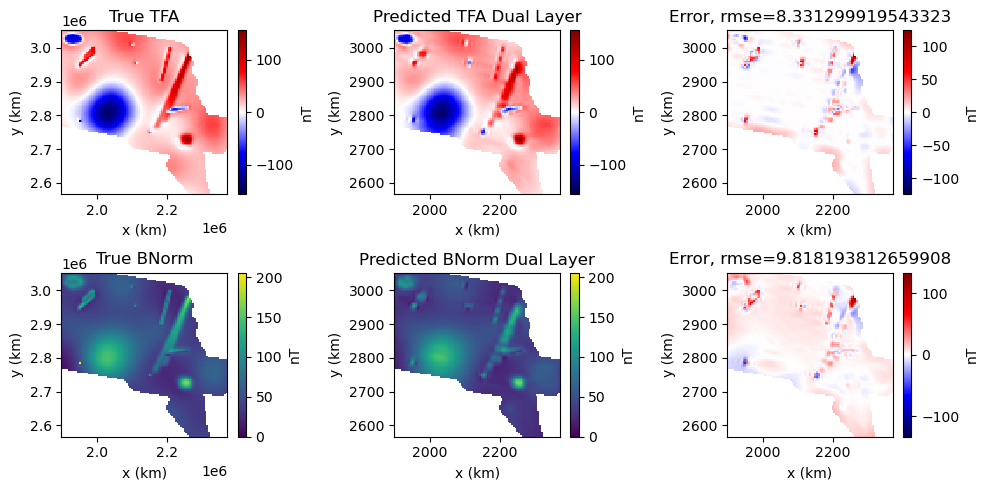

2850000.0


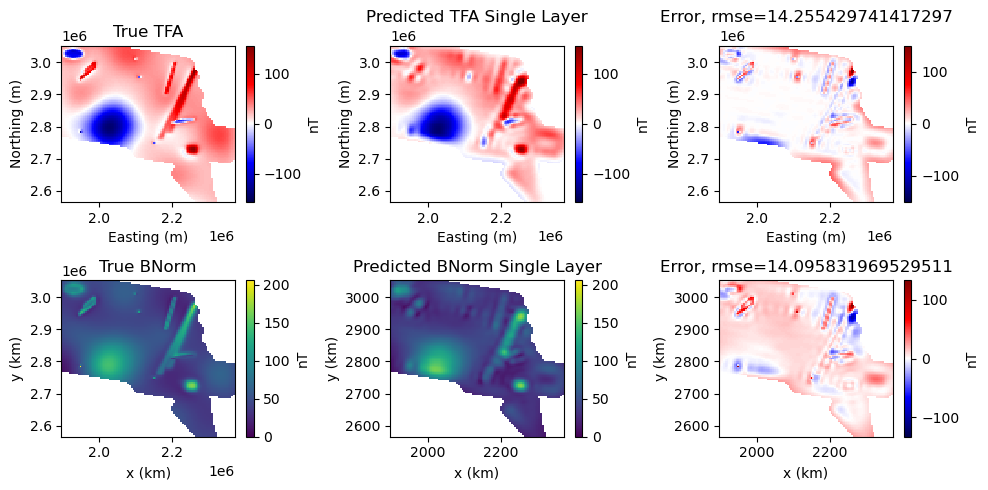

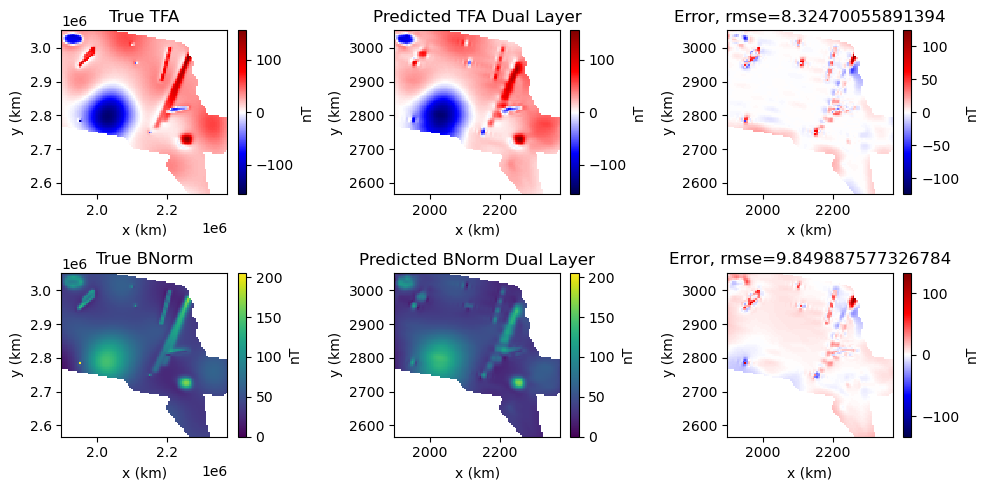

2840000.0


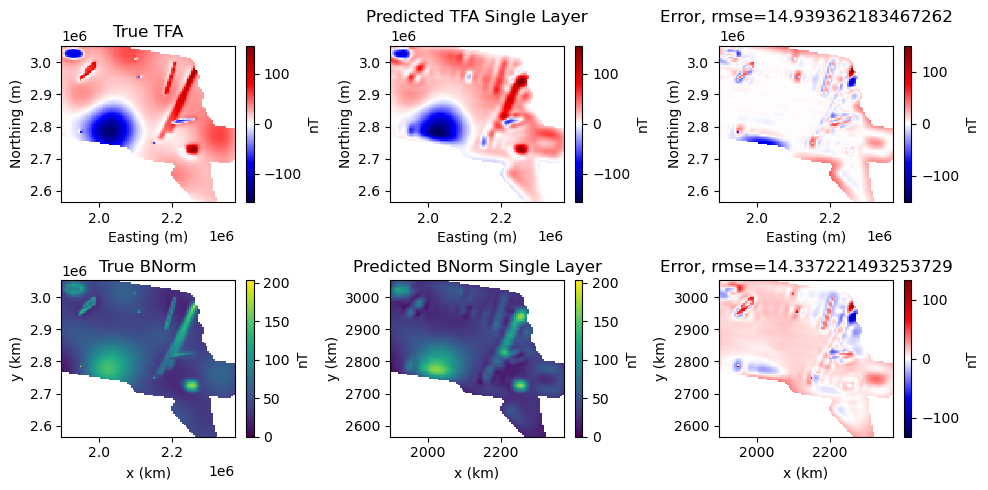

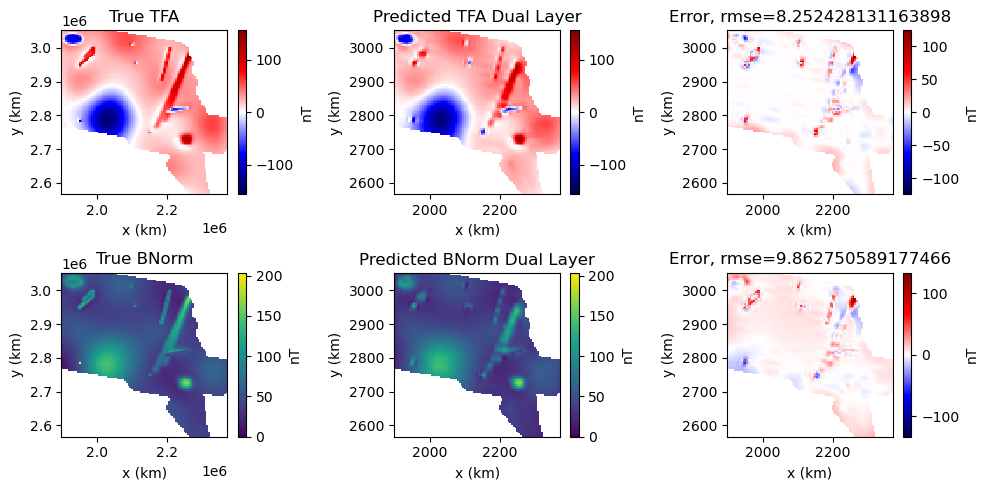

2830000.0


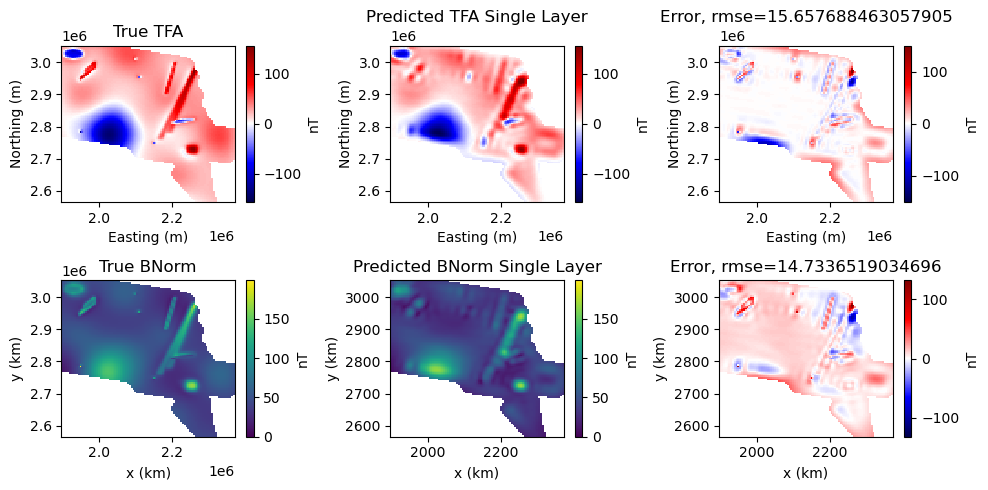

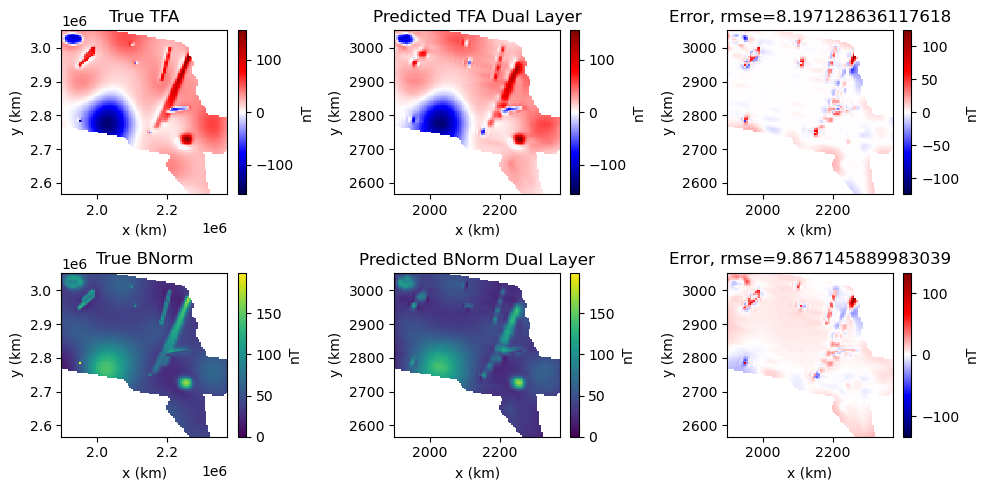

2820000.0


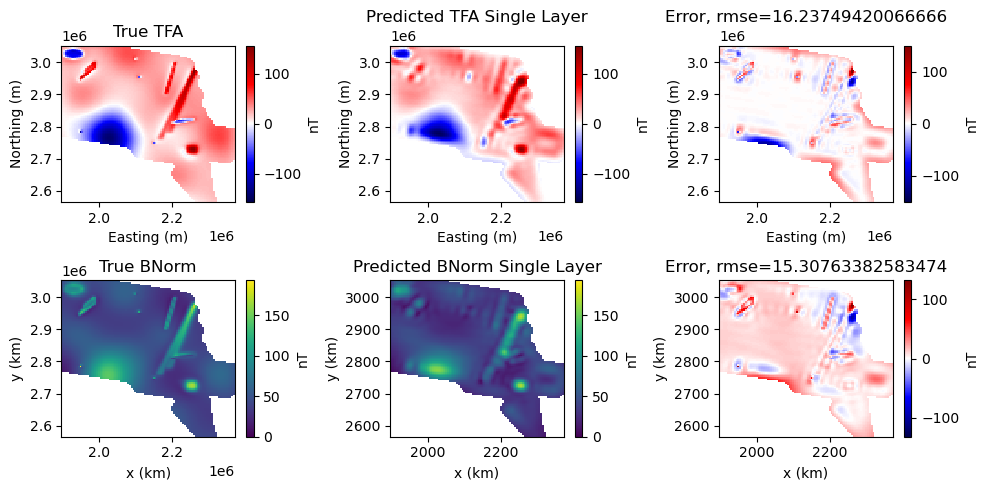

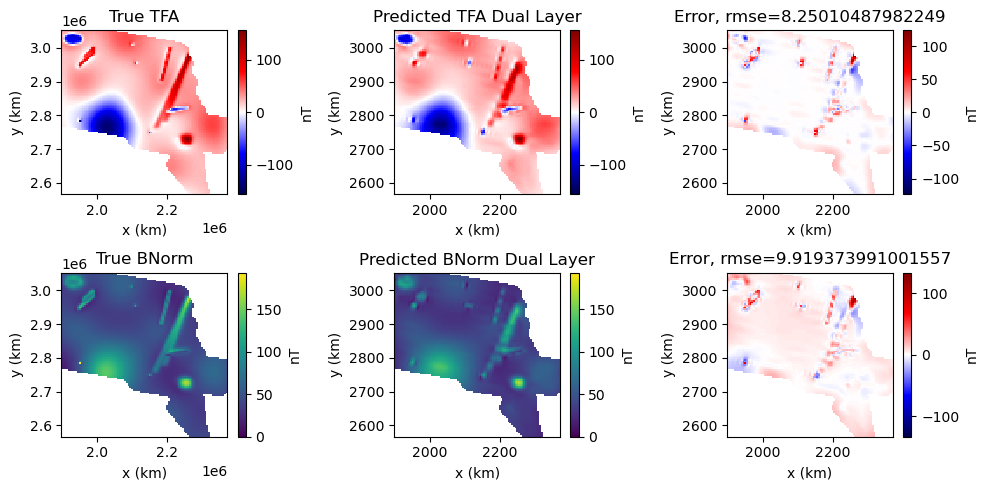

2810000.0


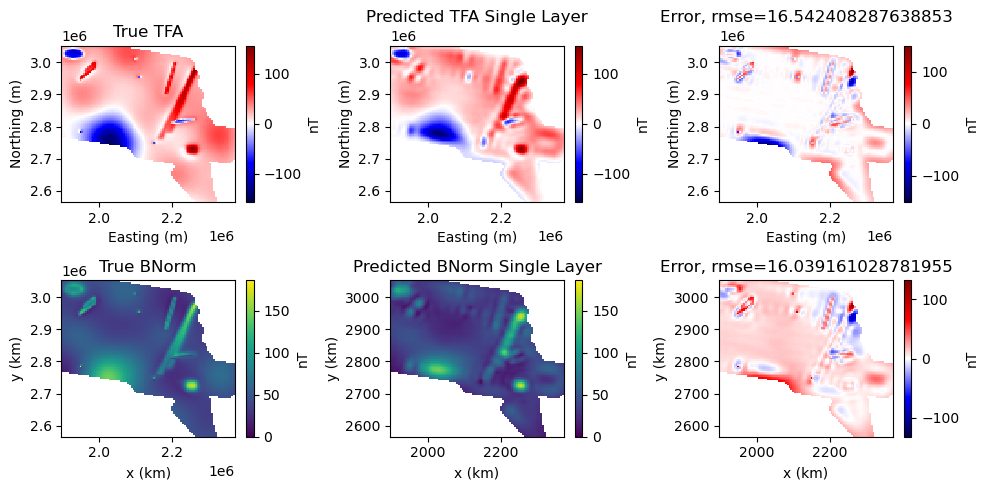

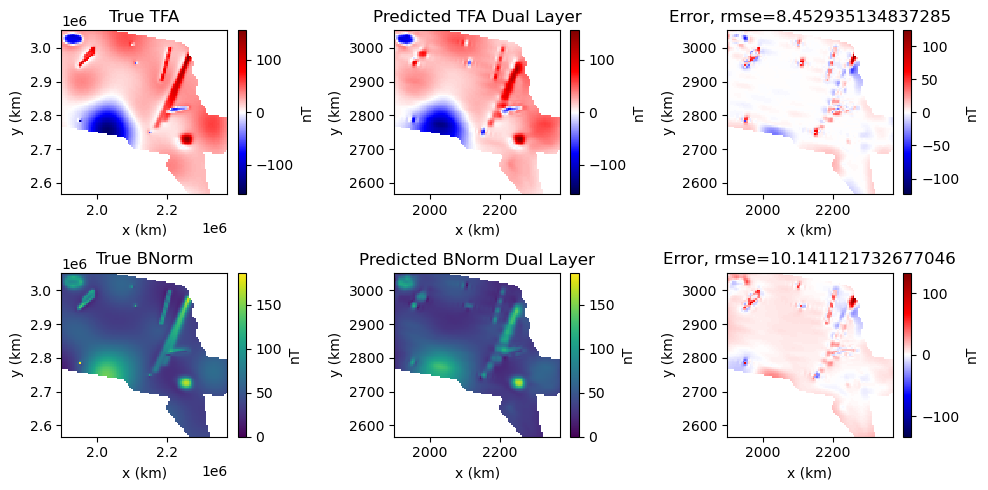

2800000.0


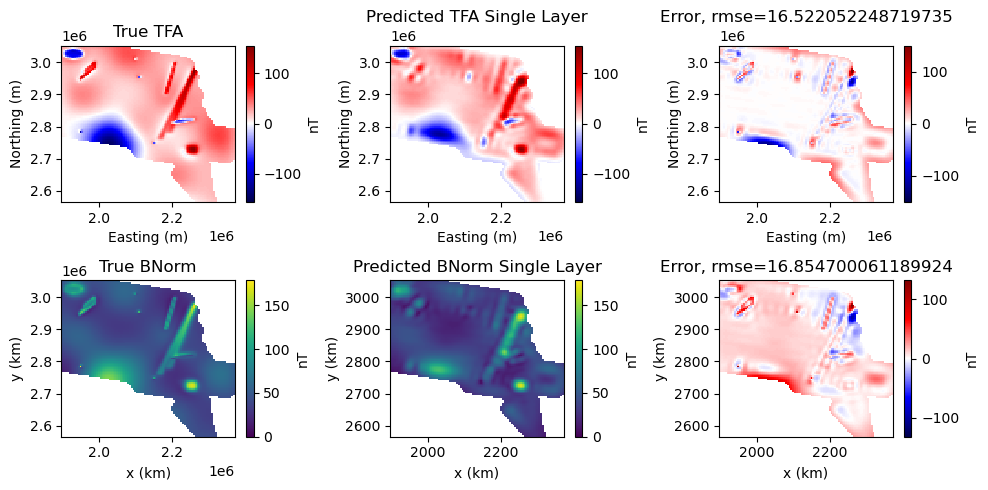

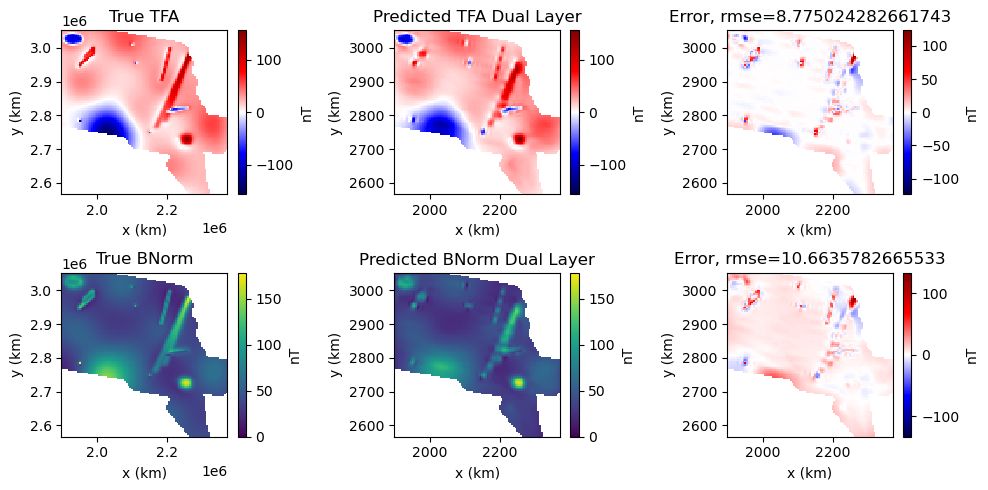

2790000.0


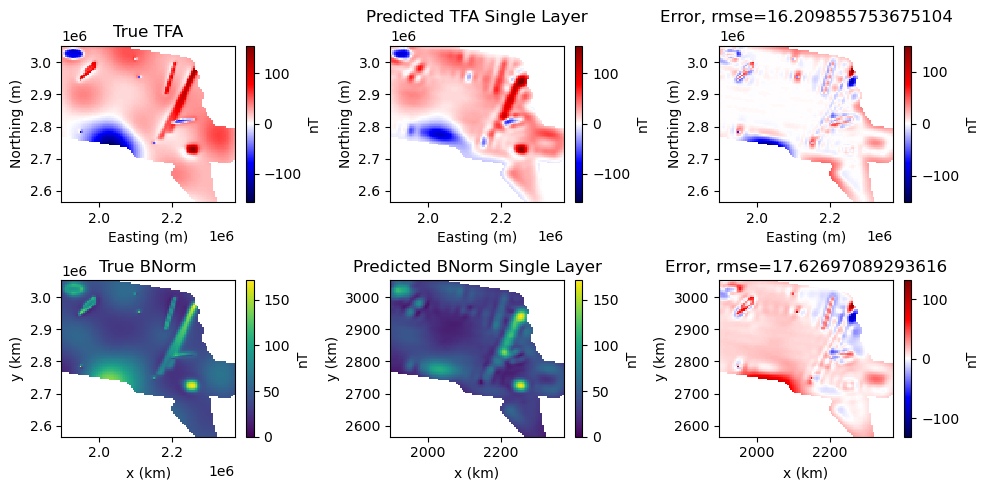

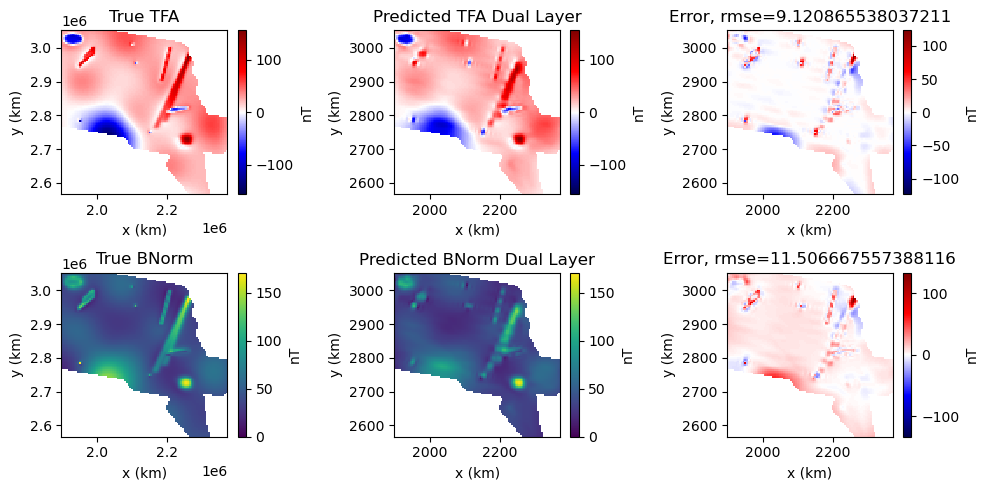

2780000.0


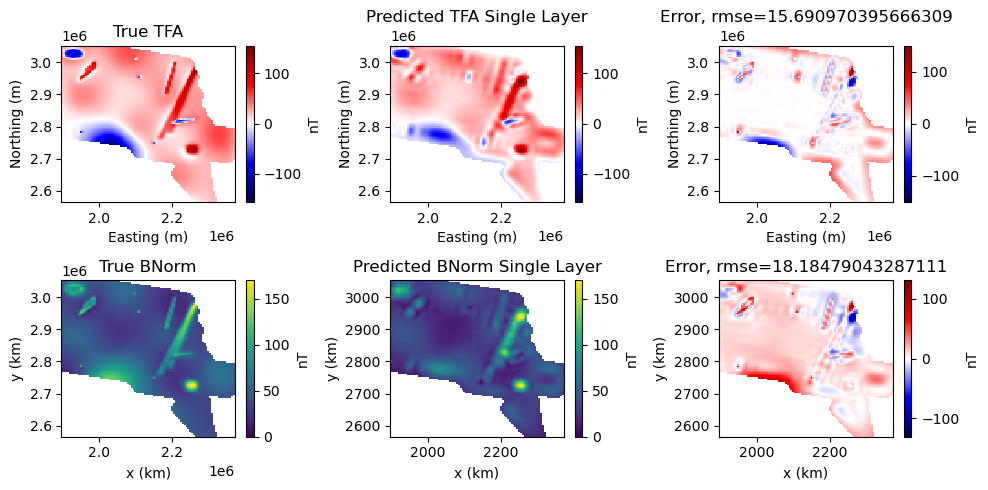

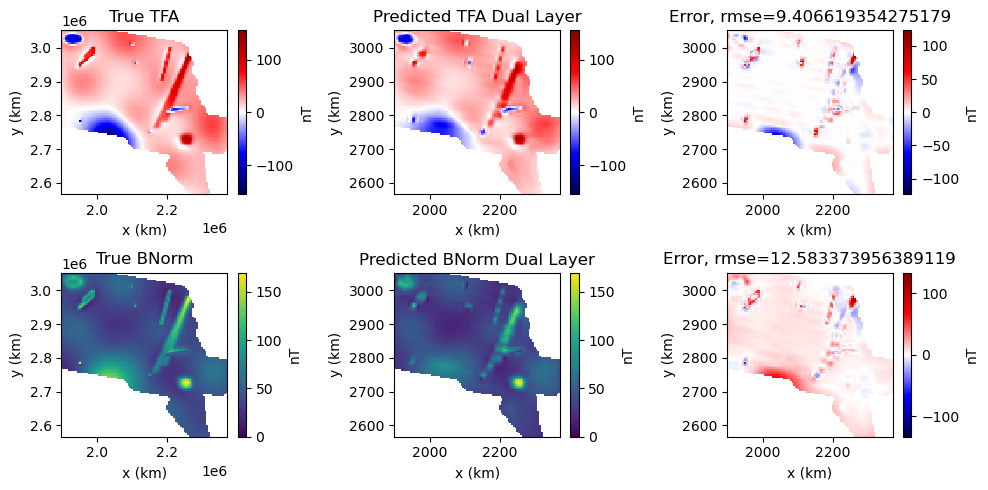

2770000.0


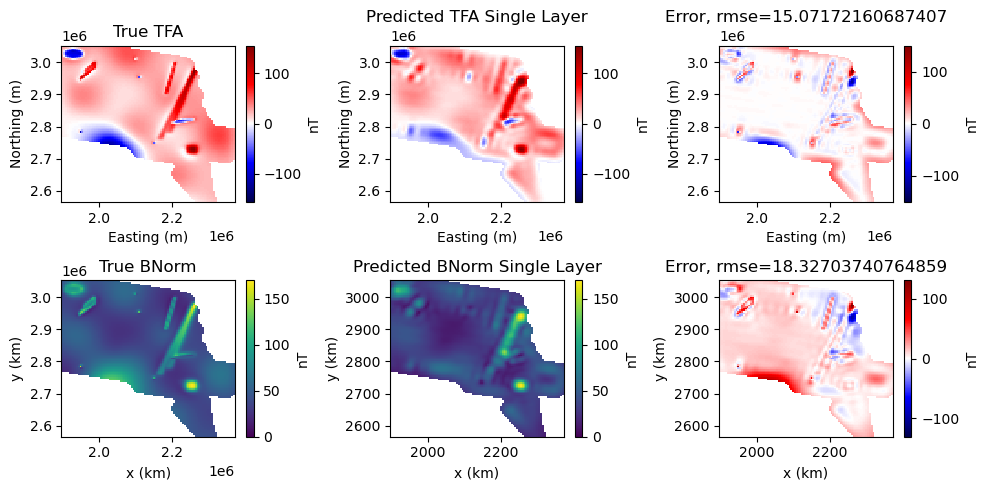

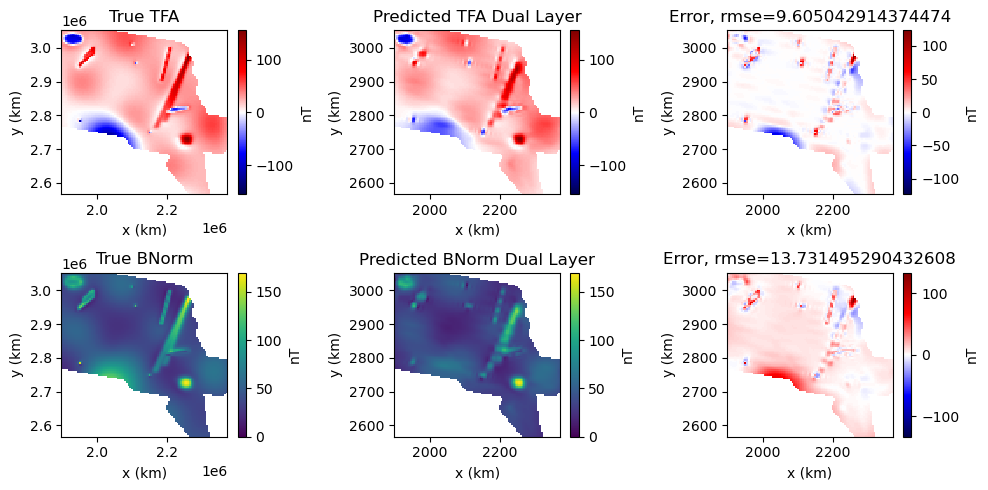

2760000.0


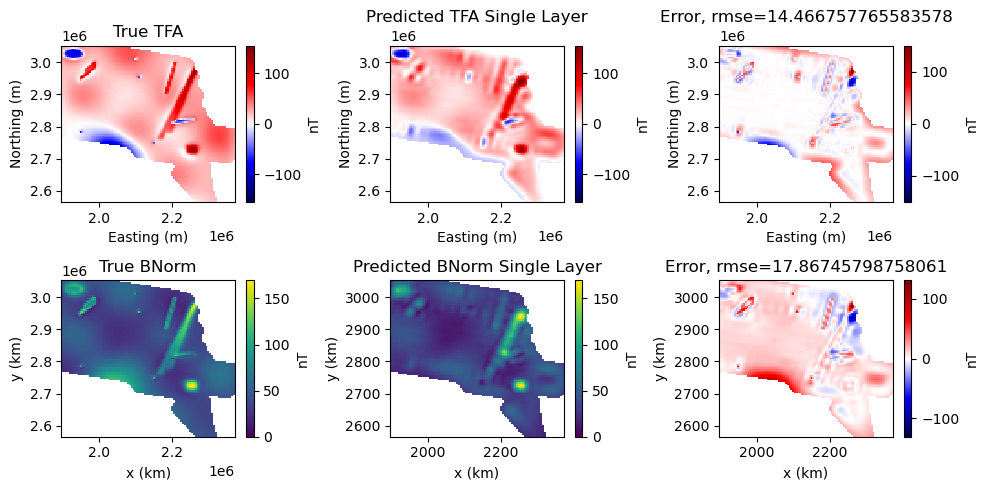

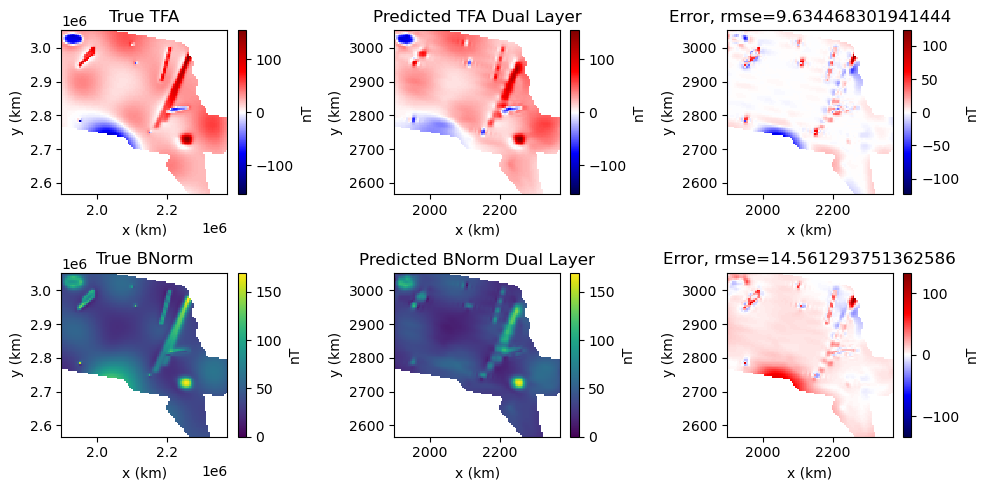

2750000.0


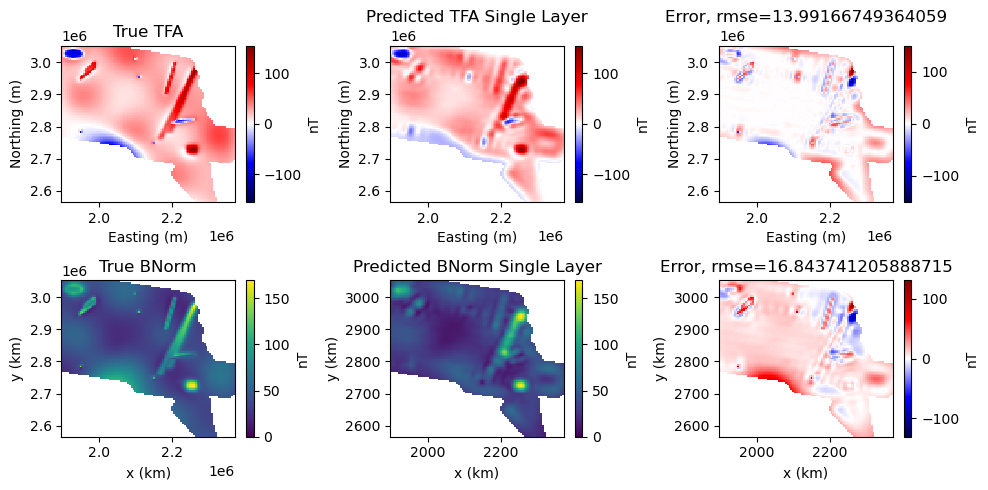

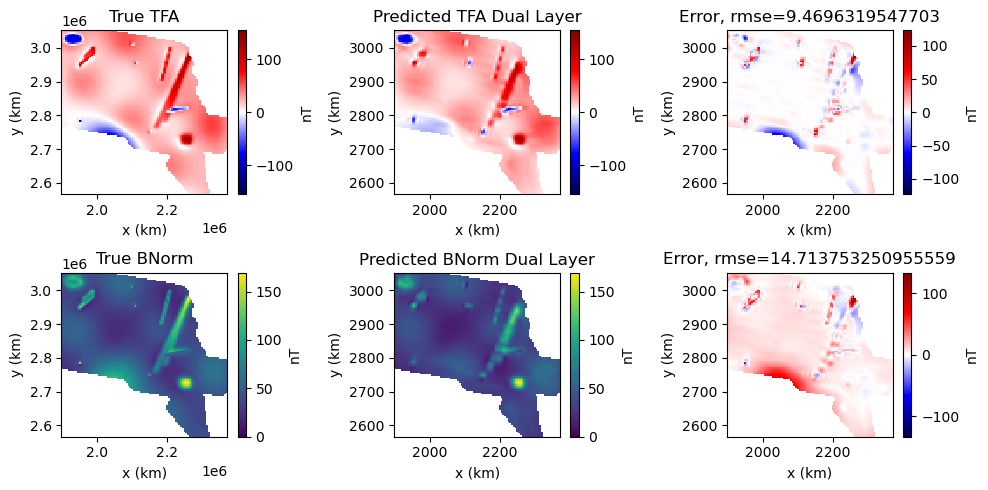

2740000.0


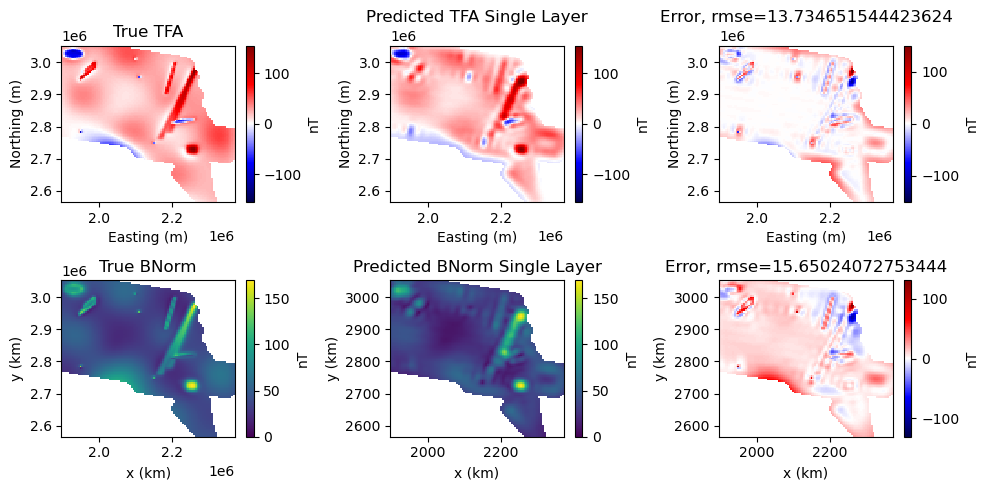

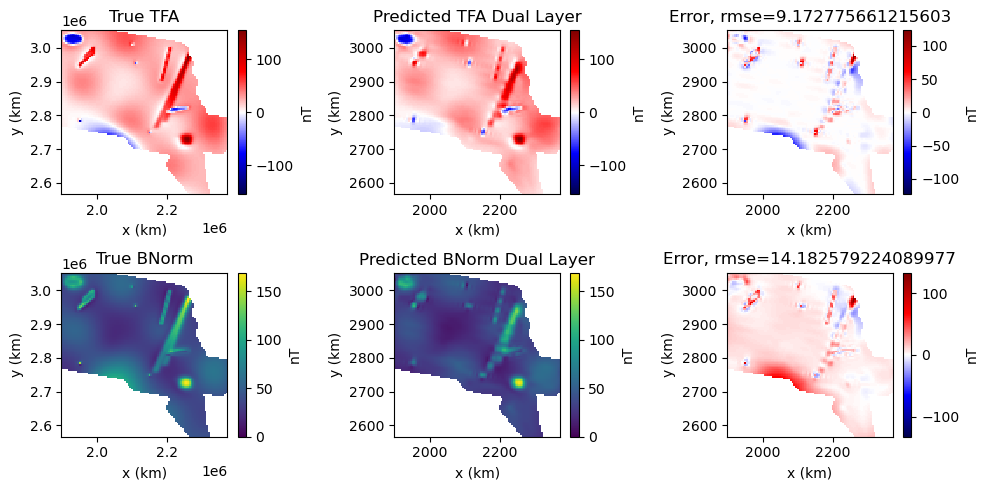

2730000.0


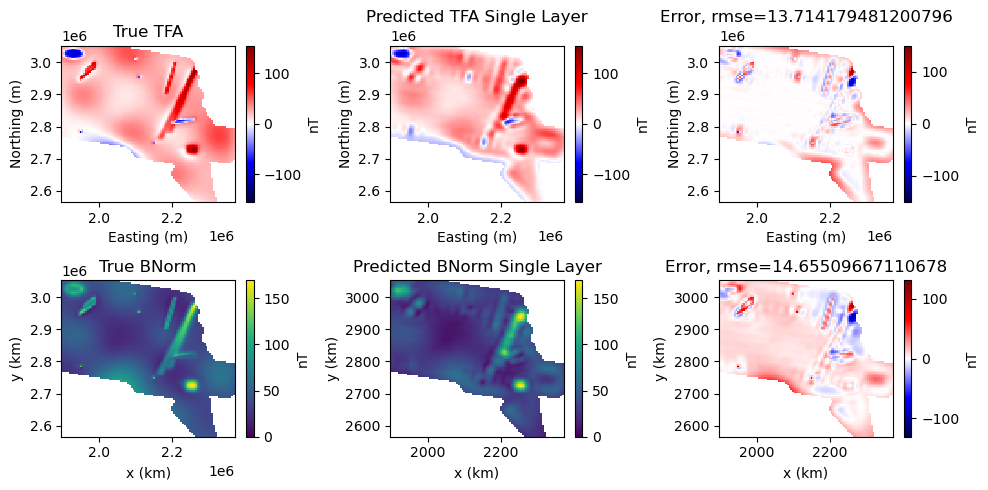

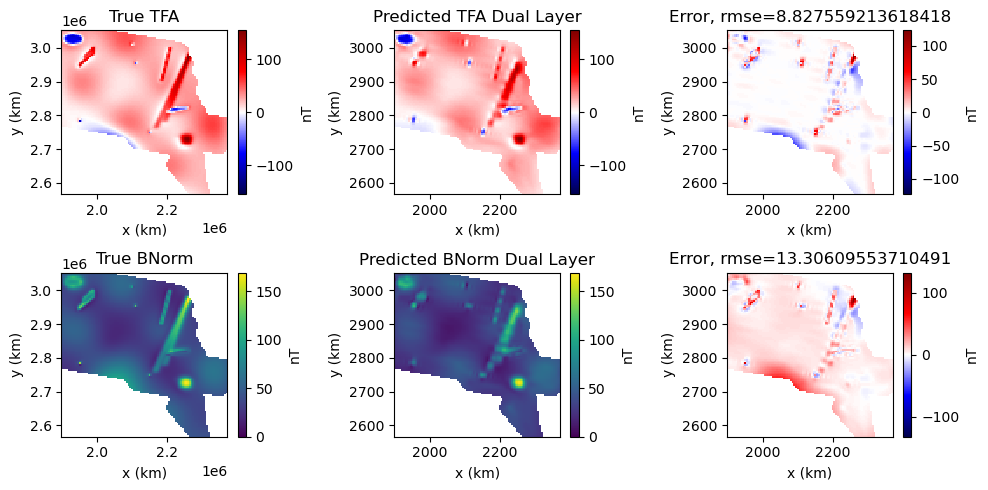

2720000.0


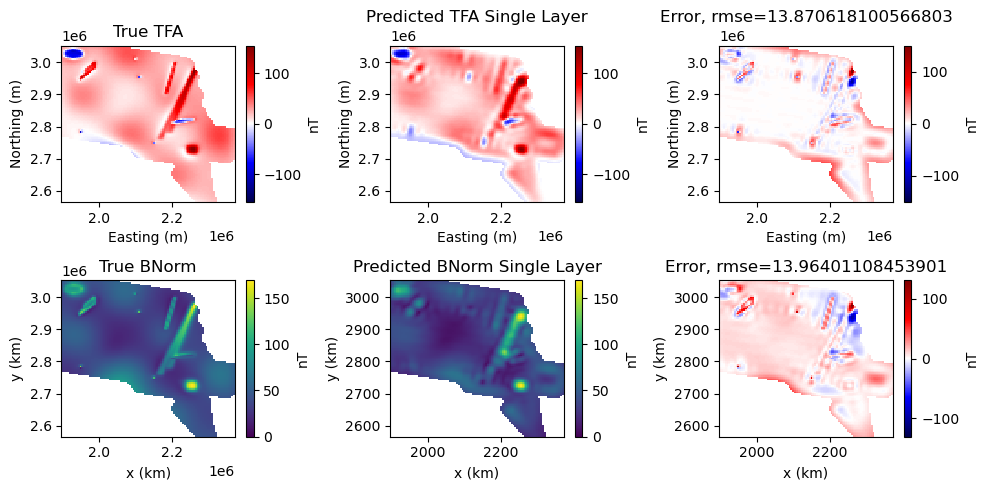

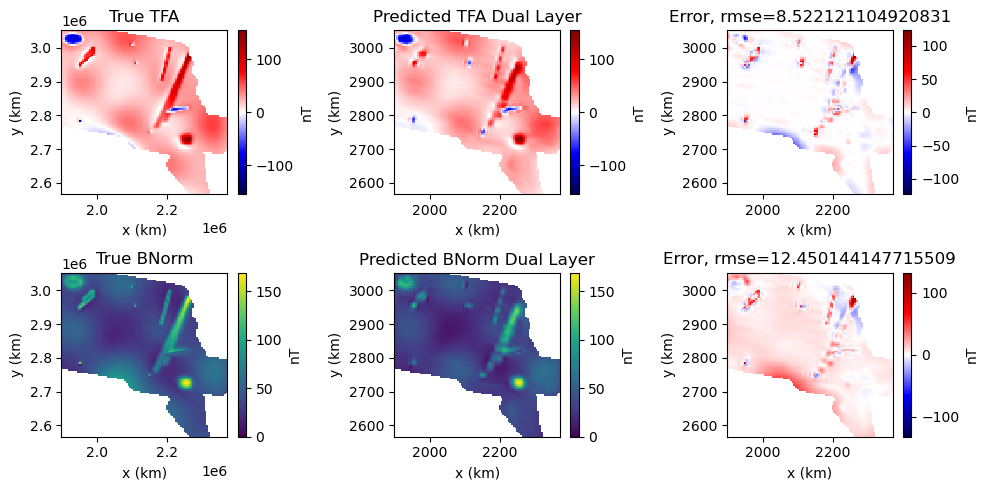

2710000.0


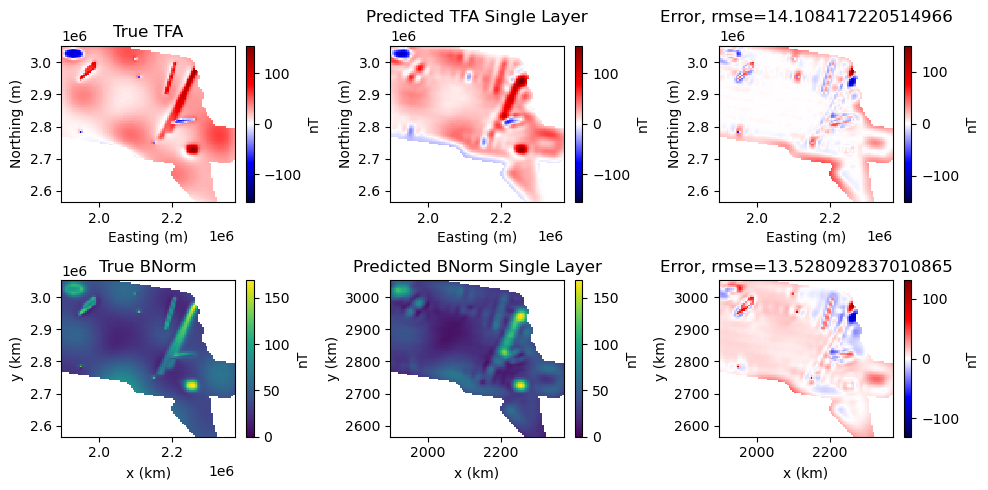

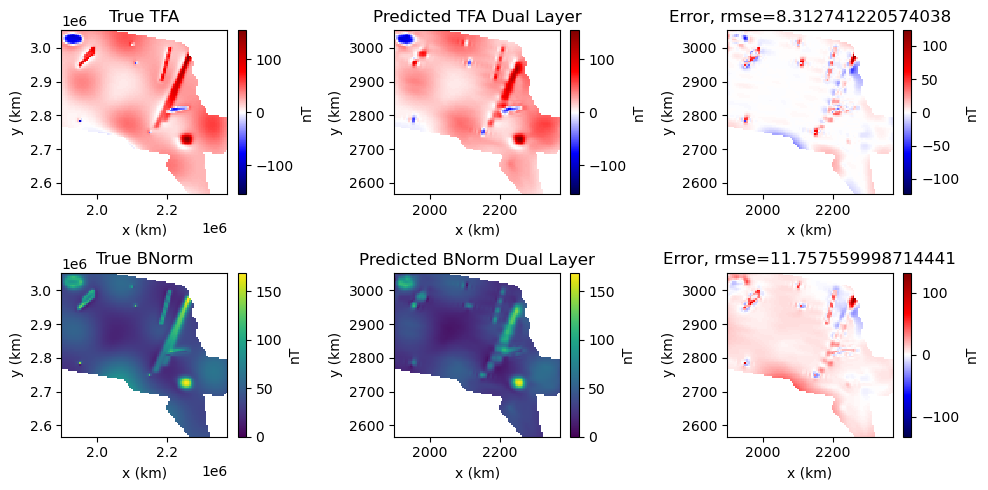

2700000.0


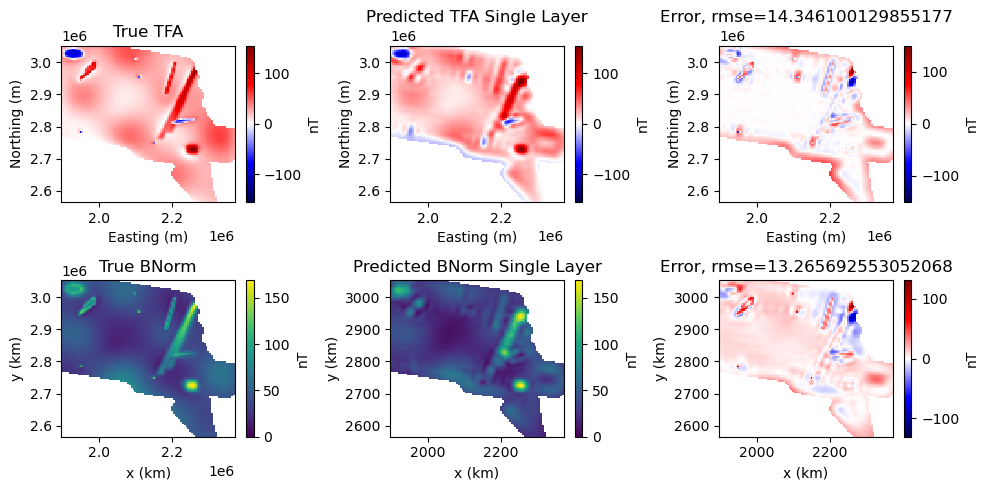

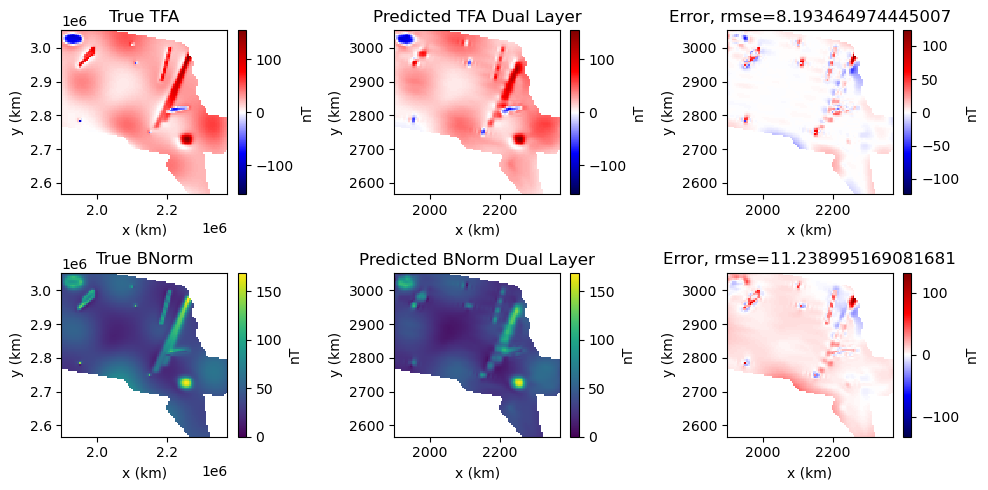

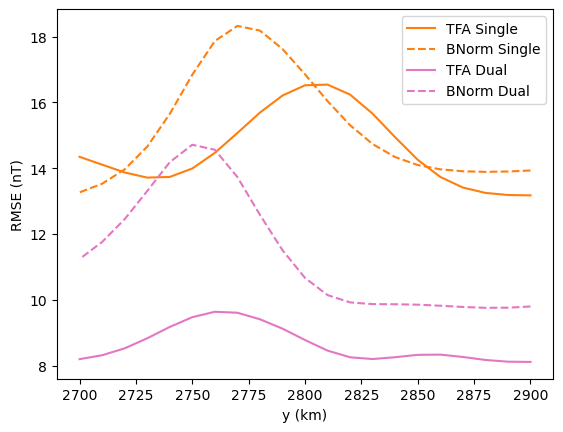

In [5]:
regional_dipole_height = -70e3
regional_dipole_moment = 2e13
regional_dipole_direction = [55,45]

window_size = 250e3
damping_1layer = 1e2
depth_1layer = 35e3
block_spacing = 25e3
reducer = vd.BlockReduce(
    reduction=np.median,
    spacing=block_spacing,
    region=(vd.pad_region(region, pad=block_spacing*0.2)),
    drop_coords=False
)

all_rmses_tfa_1layer = []
all_rmses_bnorm_1layer = []

all_rmses_tfa = []
all_rmses_bnorm = []

# regional_dipole_x = [2050e3, 2075e3, 2100e3, 2125e3, 2150e3, 2175e3, 2200e3, 2225e3, 2250e3, 2275e3, 2300e3, 2325e3]
# regional_dipole_x = [2050e3, 2025e3, 2000e3, 1975e3, 1950e3, 1940e3, 1930e3, 1920e3, 1900e3, 1890e3, 1880e3, 1870e3, 1860e3]
regional_dipole_x = [2050e3]
regional_dipole_y_values = [2900e3, 2890e3, 2880e3, 2870e3, 2860e3, 2850e3, 2840e3, 2830e3, 2820e3, 2810e3, 2800e3, 2790e3, 2780e3, 2770e3, 2760e3, 2750e3, 2740e3, 2730e3, 2720e3, 2710e3, 2700e3]
# regional_dipole_y = [2925e3]

for x in regional_dipole_x:
    for y in regional_dipole_y_values:
        print(y)
        source_coordinates, dipole_moments = synthetics.truncated_regional_synthetic(
            source1=[75,60],
            source2=[-60,45],
            source3=[50,70],
            source4=[-70,40],
            dyke1=[-70,80],
            dyke2=[-70,80],
            dipoles=[45,-65],
            regional=[-50,40]   
        )
        regional_dipole_coords = [
            [[x-15e3], [y], [regional_dipole_height]],
            [[x], [y], [regional_dipole_height]],
            [[x-30e3], [y-15e3], [regional_dipole_height]],
            [[x-15e3], [y-15e3], [regional_dipole_height]],
            [[x], [y-15e3], [regional_dipole_height]],
            [[x+25e3], [y-15e3], [regional_dipole_height]],
            [[x-30e3], [y-30e3], [regional_dipole_height]],
            [[x-15e3], [y-30e3], [regional_dipole_height]],
            [[x], [y-30e3], [regional_dipole_height]],
            [[x+25e3], [y-10e3], [regional_dipole_height]],
            [[x-45e3], [y-45e3], [regional_dipole_height]],
            [[x-30e3], [y-45e3], [regional_dipole_height]],
            [[x-15e3], [y-45e3], [regional_dipole_height]],
            [[x], [y-45e3], [regional_dipole_height]],
            [[x+25e3], [y-45e3], [regional_dipole_height]],
            [[x+40e3], [y-45e3], [regional_dipole_height]],
            [[x+50e3], [y-45e3], [regional_dipole_height]],
            [[x-45e3], [y-60e3], [regional_dipole_height]],
            [[x-30e3], [y-60e3], [regional_dipole_height]],
            [[x-15e3], [y-60e3], [regional_dipole_height]],
            [[x], [y-60e3], [regional_dipole_height]],
            [[x+25e3], [y-60e3], [regional_dipole_height]],
            [[x+40e3], [y-60e3], [regional_dipole_height]],
            [[x-50e3], [y-60e3], [regional_dipole_height]],
            [[x-30e3], [y-75e3], [regional_dipole_height]],
            [[x-15e3], [y-75e3], [regional_dipole_height]],
            [[x], [2850e3], [regional_dipole_height]],
            [[x+25e3], [y-75e3], [regional_dipole_height]],
            [[x-30e3], [y-75e3], [regional_dipole_height]],
            [[x-15e3], [y-75e3], [regional_dipole_height]],
            [[x], [y-90e3], [regional_dipole_height]],
            [[x+15e3], [y-90e3], [regional_dipole_height]],
            [[x-15e3], [y-95e3], [regional_dipole_height]],
            [[x], [y-95e3], [regional_dipole_height]],   
        ]
        coords = []
        dm = []
        for coord in regional_dipole_coords:
            coords.append(coord)            
            _dipole_moment_e, _dipole_moment_n, _dipole_moment_u = hm.magnetic_angles_to_vec(regional_dipole_moment, regional_dipole_direction[0], regional_dipole_direction[1])
            dm.append(np.array([[_dipole_moment_e], [_dipole_moment_n], [_dipole_moment_u]]))
        coords = np.concatenate(coords, axis=1)
        dm = np.concatenate(dm, axis=1)
        source_coordinates = np.append(source_coordinates, coords, axis=1)
        dipole_moments = np.append(dipole_moments, dm, axis=1)

        # SYNTHETIC
        b_field = eqs.dipole_magnetic(coordinates, source_coordinates, dipole_moments)
        tfa = eqs.total_field_anomaly(b_field, field_direction)
        bnorm = eqs.magnetic_field_norm(b_field)
        coords_blocked, tfa_blocked = reducer.filter(coordinates, data=tfa)

        true_b = eqs.dipole_magnetic(grid_coords_masked, source_coordinates, dipole_moments)
        true_tfa = eqs.total_field_anomaly(true_b, field_direction)
        true_bnorm = true_bnorm = np.sqrt(sum(c**2 for c in true_b))

        # ONE LAYER EQS
        eqs_shallow_1layer = eqs.EquivalentSourcesMagneticGB(
            random_state=0,
            block_size=grid_spacing,
            window_size=window_size,
            damping=damping_1layer,
            depth=depth_1layer,
            repeat=2,
        )
        eqs_shallow_1layer.fit(coordinates, tfa, field_direction)
        predicted_b_grid_1layer = eqs_shallow_1layer.predict(grid_coords_masked)
        predicted_tfa_grid_1layer = eqs.total_field_anomaly(predicted_b_grid_1layer, field_direction)
        error_tfa_grid_1layer = true_tfa - predicted_tfa_grid_1layer
        rmse_tfa_grid_1layer = np.sqrt(np.nanmean((error_tfa_grid_1layer)**2))
        predicted_bnorm_grid_1layer = np.sqrt(sum(c**2 for c in predicted_b_grid_1layer))
        error_bnorm_grid_1layer = true_bnorm - predicted_bnorm_grid_1layer
        rmse_bnorm_grid_1layer = np.sqrt(np.nanmean((error_bnorm_grid_1layer)**2))
        all_rmses_tfa_1layer.append(rmse_tfa_grid_1layer)
        all_rmses_bnorm_1layer.append(rmse_bnorm_grid_1layer)

        # DUAL LAYER EQS
        eqs_deep = eqs.EquivalentSourcesMagnetic(damping=1, depth=147e3)
        eqs_deep.fit(coords_blocked, tfa_blocked, field_direction)
        tfa_deep = eqs.total_field_anomaly(eqs_deep.predict(coordinates), field_direction)
        tfa_residuals = tfa - tfa_deep
        eqs_shallow = eqs.EquivalentSourcesMagneticGB(random_state=0, window_size=window_size, block_size=grid_spacing, damping=1e2, depth=17e3)
        eqs_shallow.fit(coordinates, tfa_residuals, field_direction)
        predicted_b_grid = eqs_deep.predict(grid_coords_masked) + eqs_shallow.predict(grid_coords_masked)
        predicted_tfa_grid = eqs.total_field_anomaly(predicted_b_grid, field_direction)
        error_tfa_grid = true_tfa - predicted_tfa_grid
        rmse_tfa_grid = np.sqrt(np.nanmean((error_tfa_grid)**2))
        predicted_bnorm_grid = np.sqrt(sum(c**2 for c in predicted_b_grid))
        error_bnorm_grid = true_bnorm - predicted_bnorm_grid
        rmse_bnorm_grid = np.sqrt(np.nanmean((error_bnorm_grid)**2))
        all_rmses_tfa.append(rmse_tfa_grid)
        all_rmses_bnorm.append(rmse_bnorm_grid)

        scale_tfa = vd.maxabs(true_tfa)
        plt.figure(figsize=(10,5))
        plt.subplot(2,3,1)
        plt.pcolormesh(*grid_coordinates[:2], true_tfa, cmap="seismic", vmin=-scale_tfa, vmax=scale_tfa)
        plt.title("True TFA")
        plt.xlabel("Easting (m)")
        plt.ylabel("Northing (m)")
        plt.colorbar(label="nT")
        plt.subplot(2,3,2)
        plt.pcolormesh(*grid_coordinates[:2], predicted_tfa_grid_1layer, cmap="seismic", vmin=-scale_tfa, vmax=scale_tfa)
        plt.title("Predicted TFA Single Layer")
        plt.xlabel("Easting (m)")
        plt.ylabel("Northing (m)")
        plt.colorbar(label="nT")
        plt.subplot(2,3,3)
        diff_scale = vd.maxabs(error_tfa_grid_1layer)
        plt.pcolormesh(*grid_coordinates[:2], error_tfa_grid_1layer, cmap="seismic", vmin=-diff_scale, vmax=diff_scale)
        plt.title('Error, rmse={}'.format(rmse_tfa_grid_1layer))
        plt.xlabel("Easting (m)")
        plt.ylabel("Northing (m)")
        plt.colorbar(label="nT")
        plt.tight_layout()
        scale_b = vd.maxabs(true_bnorm)
        plt.subplot(2,3,4)
        plt.pcolormesh(*grid_coordinates[:2], true_bnorm, cmap="viridis", vmin=0, vmax=scale_b)
        plt.title("True BNorm")
        plt.xlabel("x (km)")
        plt.ylabel("y (km)")
        plt.colorbar(label="nT")
        plt.subplot(2,3,5)
        plt.pcolormesh(*grid_coordinates_km[:2], predicted_bnorm_grid_1layer, cmap="viridis", vmin=0, vmax=scale_b)
        plt.title("Predicted BNorm Single Layer")
        plt.xlabel("x (km)")
        plt.ylabel("y (km)")
        plt.colorbar(label="nT")
        plt.subplot(2,3,6)
        diff_scale = vd.maxabs(error_bnorm_grid_1layer)
        plt.pcolormesh(*grid_coordinates_km[:2], error_bnorm_grid_1layer, cmap="seismic", vmin=-diff_scale, vmax=diff_scale)
        plt.title('Error, rmse={}'.format(rmse_bnorm_grid_1layer))
        plt.xlabel("x (km)")
        plt.ylabel("y (km)")
        plt.colorbar(label="nT")
        plt.tight_layout()
        plt.show()

        scale_tfa = vd.maxabs(true_tfa)
        plt.figure(figsize=(10,5))
        plt.subplot(2,3,1)
        plt.pcolormesh(*grid_coordinates[:2], true_tfa, cmap="seismic", vmin=-scale_tfa, vmax=scale_tfa)
        plt.title("True TFA")
        plt.xlabel("x (km)")
        plt.ylabel("y (km)")
        plt.colorbar(label="nT")
        plt.subplot(2,3,2)
        plt.pcolormesh(*grid_coordinates_km[:2], predicted_tfa_grid, cmap="seismic", vmin=-scale_tfa, vmax=scale_tfa)
        plt.title("Predicted TFA Dual Layer")
        plt.xlabel("x (km)")
        plt.ylabel("y (km)")
        plt.colorbar(label="nT")
        plt.subplot(2,3,3)
        diff_scale = vd.maxabs(error_tfa_grid)
        plt.pcolormesh(*grid_coordinates_km[:2], error_tfa_grid, cmap="seismic", vmin=-diff_scale, vmax=diff_scale)
        plt.title('Error, rmse={}'.format(rmse_tfa_grid))
        plt.xlabel("x (km)")
        plt.ylabel("y (km)")
        plt.colorbar(label="nT")
        plt.tight_layout()
        scale_b = vd.maxabs(true_bnorm)
        plt.subplot(2,3,4)
        plt.pcolormesh(*grid_coordinates[:2], true_bnorm, cmap="viridis", vmin=0, vmax=scale_b)
        plt.title("True BNorm")
        plt.xlabel("x (km)")
        plt.ylabel("y (km)")
        plt.colorbar(label="nT")
        plt.subplot(2,3,5)
        plt.pcolormesh(*grid_coordinates_km[:2], predicted_bnorm_grid, cmap="viridis", vmin=0, vmax=scale_b)
        plt.title("Predicted BNorm Dual Layer")
        plt.xlabel("x (km)")
        plt.ylabel("y (km)")
        plt.colorbar(label="nT")
        plt.subplot(2,3,6)
        diff_scale = vd.maxabs(error_bnorm_grid)
        plt.pcolormesh(*grid_coordinates_km[:2], error_bnorm_grid, cmap="seismic", vmin=-diff_scale, vmax=diff_scale)
        plt.title('Error, rmse={}'.format(rmse_bnorm_grid))
        plt.xlabel("x (km)")
        plt.ylabel("y (km)")
        plt.colorbar(label="nT")
        plt.tight_layout()
        plt.show()

regional_dipole_x_km = [coord / 1000 for coord in regional_dipole_x]
regional_dipole_y_km = [coord / 1000 for coord in regional_dipole_y_values]

plt.figure()
# plt.plot(regional_dipole_x_km, all_rmses_tfa_1layer, label='TFA Single', linestyle='-', color='tab:orange')
# plt.plot(regional_dipole_x_km, all_rmses_bnorm_1layer, label='BNorm Single', linestyle='--', color='tab:orange')
# plt.plot(regional_dipole_x_km, all_rmses_tfa, label='TFA Dual', linestyle='-', color='tab:pink')
# plt.plot(regional_dipole_x_km, all_rmses_bnorm, label='BNorm Dual', linestyle='--', color='tab:pink')
# plt.xlabel('x (km)')
plt.plot(regional_dipole_y_km, all_rmses_tfa_1layer, label='TFA Single', linestyle='-', color='tab:orange')
plt.plot(regional_dipole_y_km, all_rmses_bnorm_1layer, label='BNorm Single', linestyle='--', color='tab:orange')
plt.plot(regional_dipole_y_km, all_rmses_tfa, label='TFA Dual', linestyle='-', color='tab:pink')
plt.plot(regional_dipole_y_km, all_rmses_bnorm, label='BNorm Dual', linestyle='--', color='tab:pink')
plt.xlabel('y (km)')
plt.ylabel('RMSE (nT)')
plt.legend()
plt.show()

# Figures for paper

In [6]:
source_coordinates, dipole_moments = synthetics.truncated_regional_synthetic(
    source1=[75,60],
    source2=[-60,45],
    source3=[50,70],
    source4=[-70,40],
    dyke1=[-70,80],
    dyke2=[-70,80],
    dipoles=[45,-65],
    regional=[-50,40]   
)
x = 2050e3
y_2880 = 2880e3
y_2800 = 2800e3
y_2730 = 2730e3

regional_dipole_coords_2880 = [
    [[x-15e3], [y_2880], [regional_dipole_height]],
    [[x], [y_2880], [regional_dipole_height]],
    [[x-30e3], [y_2880-15e3], [regional_dipole_height]],
    [[x-15e3], [y_2880-15e3], [regional_dipole_height]],
    [[x], [y_2880-15e3], [regional_dipole_height]],
    [[x+25e3], [y_2880-15e3], [regional_dipole_height]],
    [[x-30e3], [y_2880-30e3], [regional_dipole_height]],
    [[x-15e3], [y_2880-30e3], [regional_dipole_height]],
    [[x], [y_2880-30e3], [regional_dipole_height]],
    [[x+25e3], [y_2880-10e3], [regional_dipole_height]],
    [[x-45e3], [y_2880-45e3], [regional_dipole_height]],
    [[x-30e3], [y_2880-45e3], [regional_dipole_height]],
    [[x-15e3], [y_2880-45e3], [regional_dipole_height]],
    [[x], [y_2880-45e3], [regional_dipole_height]],
    [[x+25e3], [y_2880-45e3], [regional_dipole_height]],
    [[x+40e3], [y_2880-45e3], [regional_dipole_height]],
    [[x+50e3], [y_2880-45e3], [regional_dipole_height]],
    [[x-45e3], [y_2880-60e3], [regional_dipole_height]],
    [[x-30e3], [y_2880-60e3], [regional_dipole_height]],
    [[x-15e3], [y_2880-60e3], [regional_dipole_height]],
    [[x], [y_2880-60e3], [regional_dipole_height]],
    [[x+25e3], [y_2880-60e3], [regional_dipole_height]],
    [[x+40e3], [y_2880-60e3], [regional_dipole_height]],
    [[x-50e3], [y_2880-60e3], [regional_dipole_height]],
    [[x-30e3], [y_2880-75e3], [regional_dipole_height]],
    [[x-15e3], [y_2880-75e3], [regional_dipole_height]],
    [[x], [2850e3], [regional_dipole_height]],
    [[x+25e3], [y_2880-75e3], [regional_dipole_height]],
    [[x-30e3], [y_2880-75e3], [regional_dipole_height]],
    [[x-15e3], [y_2880-75e3], [regional_dipole_height]],
    [[x], [y_2880-90e3], [regional_dipole_height]],
    [[x+15e3], [y_2880-90e3], [regional_dipole_height]],
    [[x-15e3], [y_2880-95e3], [regional_dipole_height]],
    [[x], [y_2880-95e3], [regional_dipole_height]],   
]
regional_dipole_coords_2800 = [
    [[x-15e3], [y_2800], [regional_dipole_height]],
    [[x], [y_2800], [regional_dipole_height]],
    [[x-30e3], [y_2800-15e3], [regional_dipole_height]],
    [[x-15e3], [y_2800-15e3], [regional_dipole_height]],
    [[x], [y_2800-15e3], [regional_dipole_height]],
    [[x+25e3], [y_2800-15e3], [regional_dipole_height]],
    [[x-30e3], [y_2800-30e3], [regional_dipole_height]],
    [[x-15e3], [y_2800-30e3], [regional_dipole_height]],
    [[x], [y_2800-30e3], [regional_dipole_height]],
    [[x+25e3], [y_2800-10e3], [regional_dipole_height]],
    [[x-45e3], [y_2800-45e3], [regional_dipole_height]],
    [[x-30e3], [y_2800-45e3], [regional_dipole_height]],
    [[x-15e3], [y_2800-45e3], [regional_dipole_height]],
    [[x], [y_2800-45e3], [regional_dipole_height]],
    [[x+25e3], [y_2800-45e3], [regional_dipole_height]],
    [[x+40e3], [y_2800-45e3], [regional_dipole_height]],
    [[x+50e3], [y_2800-45e3], [regional_dipole_height]],
    [[x-45e3], [y_2800-60e3], [regional_dipole_height]],
    [[x-30e3], [y_2800-60e3], [regional_dipole_height]],
    [[x-15e3], [y_2800-60e3], [regional_dipole_height]],
    [[x], [y_2800-60e3], [regional_dipole_height]],
    [[x+25e3], [y_2800-60e3], [regional_dipole_height]],
    [[x+40e3], [y_2800-60e3], [regional_dipole_height]],
    [[x-50e3], [y_2800-60e3], [regional_dipole_height]],
    [[x-30e3], [y_2800-75e3], [regional_dipole_height]],
    [[x-15e3], [y_2800-75e3], [regional_dipole_height]],
    [[x], [2850e3], [regional_dipole_height]],
    [[x+25e3], [y_2800-75e3], [regional_dipole_height]],
    [[x-30e3], [y_2800-75e3], [regional_dipole_height]],
    [[x-15e3], [y_2800-75e3], [regional_dipole_height]],
    [[x], [y_2800-90e3], [regional_dipole_height]],
    [[x+15e3], [y_2800-90e3], [regional_dipole_height]],
    [[x-15e3], [y_2800-95e3], [regional_dipole_height]],
    [[x], [y_2800-95e3], [regional_dipole_height]],   
]
regional_dipole_coords_2730 = [
    [[x-15e3], [y_2730], [regional_dipole_height]],
    [[x], [y_2730], [regional_dipole_height]],
    [[x-30e3], [y_2730-15e3], [regional_dipole_height]],
    [[x-15e3], [y_2730-15e3], [regional_dipole_height]],
    [[x], [y_2730-15e3], [regional_dipole_height]],
    [[x+25e3], [y_2730-15e3], [regional_dipole_height]],
    [[x-30e3], [y_2730-30e3], [regional_dipole_height]],
    [[x-15e3], [y_2730-30e3], [regional_dipole_height]],
    [[x], [y_2730-30e3], [regional_dipole_height]],
    [[x+25e3], [y_2730-10e3], [regional_dipole_height]],
    [[x-45e3], [y_2730-45e3], [regional_dipole_height]],
    [[x-30e3], [y_2730-45e3], [regional_dipole_height]],
    [[x-15e3], [y_2730-45e3], [regional_dipole_height]],
    [[x], [y_2730-45e3], [regional_dipole_height]],
    [[x+25e3], [y_2730-45e3], [regional_dipole_height]],
    [[x+40e3], [y_2730-45e3], [regional_dipole_height]],
    [[x+50e3], [y_2730-45e3], [regional_dipole_height]],
    [[x-45e3], [y_2730-60e3], [regional_dipole_height]],
    [[x-30e3], [y_2730-60e3], [regional_dipole_height]],
    [[x-15e3], [y_2730-60e3], [regional_dipole_height]],
    [[x], [y_2730-60e3], [regional_dipole_height]],
    [[x+25e3], [y_2730-60e3], [regional_dipole_height]],
    [[x+40e3], [y_2730-60e3], [regional_dipole_height]],
    [[x-50e3], [y_2730-60e3], [regional_dipole_height]],
    [[x-30e3], [y_2730-75e3], [regional_dipole_height]],
    [[x-15e3], [y_2730-75e3], [regional_dipole_height]],
    [[x], [2850e3], [regional_dipole_height]],
    [[x+25e3], [y_2730-75e3], [regional_dipole_height]],
    [[x-30e3], [y_2730-75e3], [regional_dipole_height]],
    [[x-15e3], [y_2730-75e3], [regional_dipole_height]],
    [[x], [y_2730-90e3], [regional_dipole_height]],
    [[x+15e3], [y_2730-90e3], [regional_dipole_height]],
    [[x-15e3], [y_2730-95e3], [regional_dipole_height]],
    [[x], [y_2730-95e3], [regional_dipole_height]],   
]
coords_2880 = []
dm_2880 = []
coords_2800 = []
dm_2800 = []
coords_2730 = []
dm_2730 = []

for coord in regional_dipole_coords_2880:
    coords_2880.append(coord)
    _dipole_moment_e, _dipole_moment_n, _dipole_moment_u = hm.magnetic_angles_to_vec(regional_dipole_moment, regional_dipole_direction[0], regional_dipole_direction[1])
    dm_2880.append(np.array([[_dipole_moment_e], [_dipole_moment_n], [_dipole_moment_u]]))
coords_2880 = np.concatenate(coords_2880, axis=1)
dm_2880 = np.concatenate(dm_2880, axis=1)
source_coordinates_2880 = np.append(source_coordinates, coords_2880, axis=1)
dipole_moments_2880 = np.append(dipole_moments, dm_2880, axis=1)
true_tfa_2880 = eqs.total_field_anomaly(
    eqs.dipole_magnetic(grid_coords_masked, source_coordinates_2880, dipole_moments_2880),
    field_direction
)

for coord in regional_dipole_coords_2800:
    coords_2800.append(coord)
    _dipole_moment_e, _dipole_moment_n, _dipole_moment_u = hm.magnetic_angles_to_vec(regional_dipole_moment, regional_dipole_direction[0], regional_dipole_direction[1])
    dm_2800.append(np.array([[_dipole_moment_e], [_dipole_moment_n], [_dipole_moment_u]]))
coords_2800 = np.concatenate(coords_2800, axis=1)
dm_2800 = np.concatenate(dm_2800, axis=1)
source_coordinates_2800 = np.append(source_coordinates, coords_2800, axis=1)
dipole_moments_2800 = np.append(dipole_moments, dm_2800, axis=1)
true_tfa_2800 = eqs.total_field_anomaly(
    eqs.dipole_magnetic(grid_coords_masked, source_coordinates_2800, dipole_moments_2800),
    field_direction
)

for coord in regional_dipole_coords_2730:
    coords_2730.append(coord)
    _dipole_moment_e, _dipole_moment_n, _dipole_moment_u = hm.magnetic_angles_to_vec(regional_dipole_moment, regional_dipole_direction[0], regional_dipole_direction[1])
    dm_2730.append(np.array([[_dipole_moment_e], [_dipole_moment_n], [_dipole_moment_u]]))
coords_2730 = np.concatenate(coords_2730, axis=1)
dm_2730 = np.concatenate(dm_2730, axis=1)
source_coordinates_2730 = np.append(source_coordinates, coords_2730, axis=1)
dipole_moments_2730 = np.append(dipole_moments, dm_2730, axis=1)
true_tfa_2730 = eqs.total_field_anomaly(
    eqs.dipole_magnetic(grid_coords_masked, source_coordinates_2730, dipole_moments_2730),
    field_direction
)

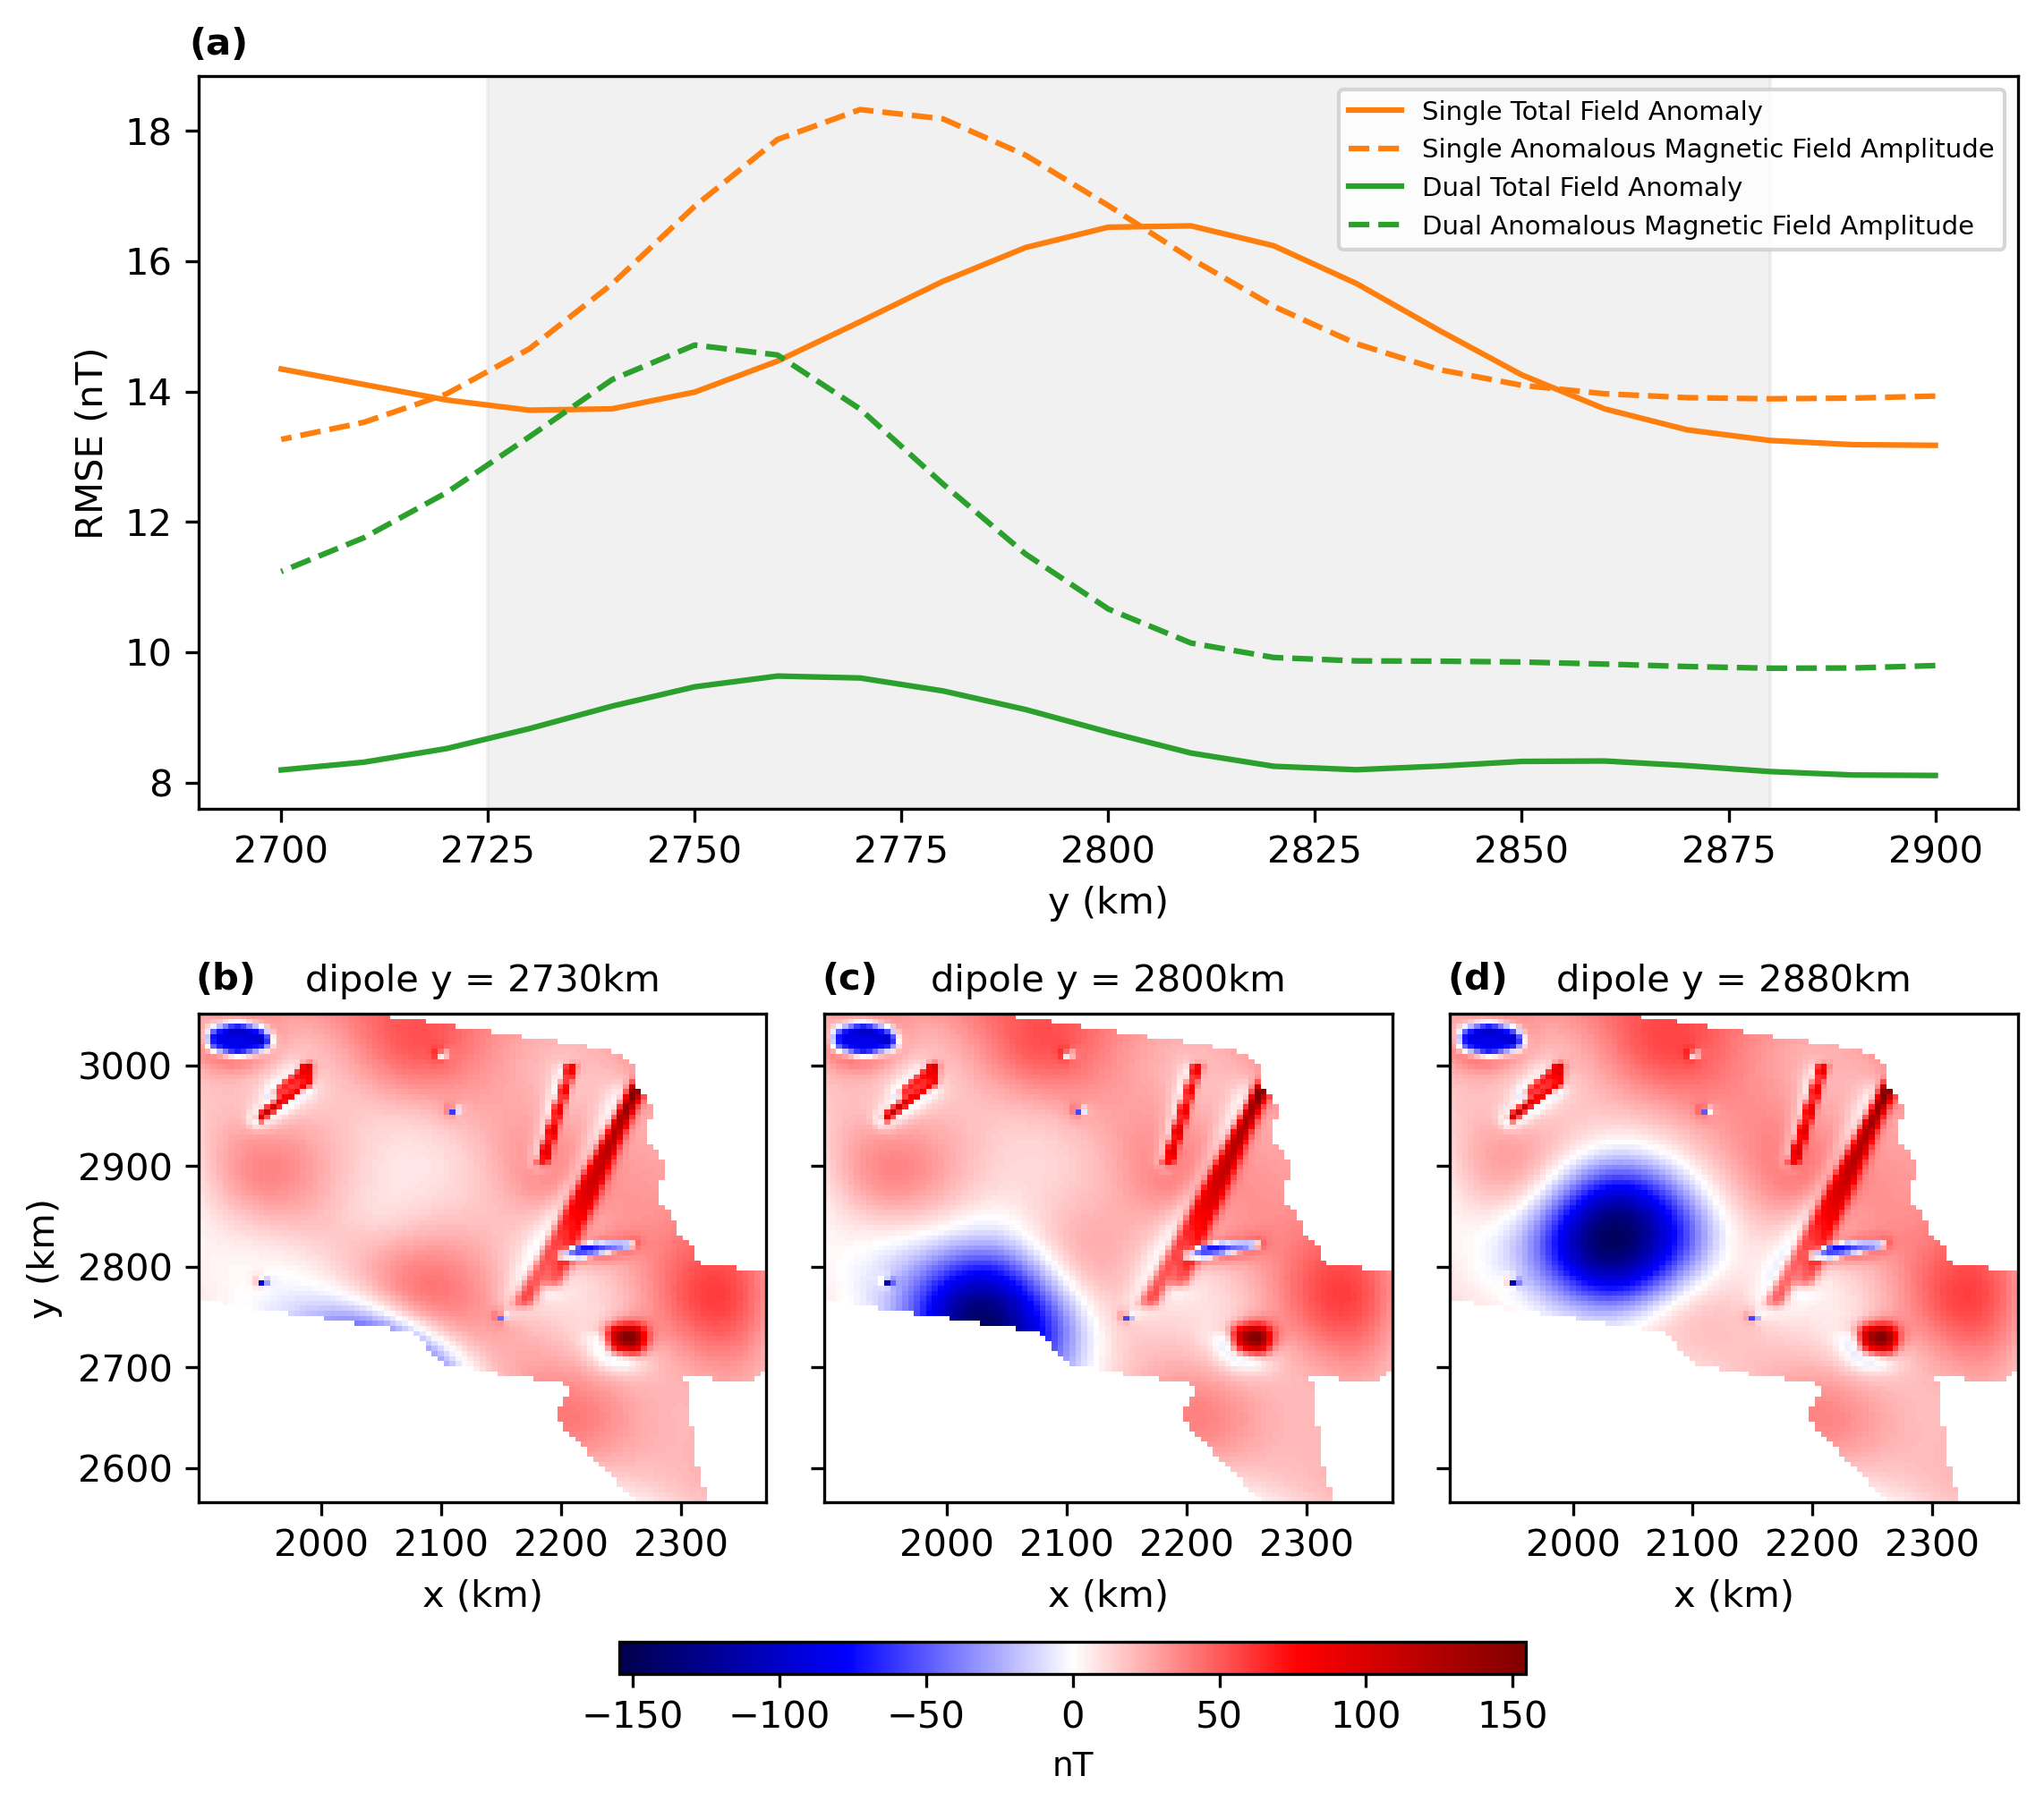

In [7]:
scale_tfa = vd.maxabs(true_tfa)

fig = plt.figure(figsize=(7.5, 6), constrained_layout=True)
# gs = gridspec.GridSpec(3, 2, width_ratios=[1.5, 1], height_ratios=[1, 1, 1], wspace=0.05, hspace=0.05, figure=fig)
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1], height_ratios=[1.5, 1], wspace=0.01, hspace=0.05, figure=fig)

# ax1 = fig.add_subplot(gs[:, 0])
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(regional_dipole_y_km, all_rmses_tfa_1layer, label='Single Total Field Anomaly', linestyle='-', color='tab:orange')
ax1.plot(regional_dipole_y_km, all_rmses_bnorm_1layer, label='Single Anomalous Magnetic Field Amplitude', linestyle='--', color='tab:orange')
ax1.plot(regional_dipole_y_km, all_rmses_tfa, label='Dual Total Field Anomaly', linestyle='-', color='tab:green')
ax1.plot(regional_dipole_y_km, all_rmses_bnorm, label='Dual Anomalous Magnetic Field Amplitude', linestyle='--', color='tab:green')
ax1.axvspan(2725, 2880, color='lightgrey', alpha=0.3)
ax1.set_xlabel('y (km)')
ax1.set_ylabel('RMSE (nT)')
ax1.text(-0.005, 1.03, '(a)', transform=ax1.transAxes, fontsize=10, fontweight='bold')
ax1.legend(fontsize=7)

# ax2 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 0])
ax2.pcolormesh(
    *grid_coordinates_km[:2],
    true_tfa_2730,
    cmap="seismic",
    vmin=-scale_tfa,
    vmax=scale_tfa,
)
ax2.set_title("dipole y = 2730km", fontsize=10)
ax2.set_xlabel("x (km)", fontsize=10)
ax2.set_xticks([2000, 2100, 2200, 2300])
ax2.set_ylabel("y (km)", fontsize=10)
ax2.set_yticks([2600, 2700, 2800, 2900, 3000])
ax2.tick_params(axis='y', labelleft=True)
ax2.text(-0.005, 1.05, '(b)', transform=ax2.transAxes, fontsize=10, fontweight='bold')

ax3 = fig.add_subplot(gs[1, 1])
ax3.pcolormesh(
    *grid_coordinates_km[:2],
    true_tfa_2800,
    cmap="seismic",
    vmin=-scale_tfa,
    vmax=scale_tfa,
)
ax3.set_title("dipole y = 2800km", fontsize=10)
ax3.set_xlabel("x (km)", fontsize=10)
ax3.set_xticks([2000, 2100, 2200, 2300])
ax3.set_yticklabels([])
ax3.text(-0.005, 1.05, '(c)', transform=ax3.transAxes, fontsize=10, fontweight='bold')

# ax4 = fig.add_subplot(gs[2, 1])
ax4 = fig.add_subplot(gs[1, 2])
plot4 = ax4.pcolormesh(
    *grid_coordinates_km[:2],
    true_tfa_2880,
    cmap="seismic",
    vmin=-scale_tfa,
    vmax=scale_tfa,
)
ax4.set_title("dipole y = 2880km", fontsize=10)
ax4.set_xlabel("x (km)", fontsize=10)
ax4.set_xticks([2000, 2100, 2200, 2300])
ax4.set_yticklabels([])
ax4.text(-0.005, 1.05, '(d)', transform=ax4.transAxes, fontsize=10, fontweight='bold')

# cax = fig.add_axes([0.68, -0.03, 0.3, 0.02])  # [left, bottom, width, height]
cax = fig.add_axes([0.3, -0.03, 0.45, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(plot4, cax=cax, orientation="horizontal", pad=0.06, shrink=0.7, aspect=30)
cbar.set_label("nT", fontsize=9)

# fig.show()
truncated_regional__rmses_figure = Path("..") / "paper" / "figures" / "truncated_regional_rmses.png"
fig.savefig(truncated_regional__rmses_figure, dpi=300, bbox_inches="tight")
plt.close()
Image(truncated_regional__rmses_figure)

In [8]:
# SYNTHETIC
b_field_2800 = eqs.dipole_magnetic(coordinates, source_coordinates_2800, dipole_moments_2800)
tfa_2800 = eqs.total_field_anomaly(b_field_2800, field_direction)
bnorm_2800 = eqs.magnetic_field_norm(b_field_2800)
coords_blocked, tfa_blocked_2800 = reducer.filter(coordinates, data=tfa_2800)

true_b_2800 = eqs.dipole_magnetic(grid_coords_masked, source_coordinates_2800, dipole_moments_2800)
true_tfa_2800 = eqs.total_field_anomaly(true_b_2800, field_direction)
true_bnorm_2800 = true_bnorm = np.sqrt(sum(c**2 for c in true_b_2800))

# ONE LAYER EQS
eqs_shallow_1layer_2800 = eqs.EquivalentSourcesMagneticGB(
    random_state=0,
    block_size=grid_spacing,
    window_size=window_size,
    damping=damping_1layer,
    depth=depth_1layer,
    repeat=2,
)
eqs_shallow_1layer_2800.fit(coordinates, tfa_2800, field_direction)
predicted_b_grid_1layer_2800 = eqs_shallow_1layer_2800.predict(grid_coords_masked)
predicted_tfa_grid_1layer_2800 = eqs.total_field_anomaly(predicted_b_grid_1layer_2800, field_direction)
predicted_bnorm_grid_1layer_2800 = np.sqrt(sum(c**2 for c in predicted_b_grid_1layer_2800))

# DUAL LAYER EQS
eqs_deep_2800 = eqs.EquivalentSourcesMagnetic(damping=1, depth=117e3)
eqs_deep_2800.fit(coords_blocked, tfa_blocked_2800, field_direction)
tfa_deep_2800 = eqs.total_field_anomaly(eqs_deep_2800.predict(coordinates), field_direction)
tfa_residuals_2800 = tfa_2800 - tfa_deep_2800
eqs_shallow_2800 = eqs.EquivalentSourcesMagneticGB(random_state=0, window_size=window_size, block_size=grid_spacing, damping=1e2, depth=17e3)
eqs_shallow_2800.fit(coordinates, tfa_residuals_2800, field_direction)
predicted_b_grid_2800 = eqs_deep_2800.predict(grid_coords_masked) + eqs_shallow_2800.predict(grid_coords_masked)
predicted_tfa_grid_2800 = eqs.total_field_anomaly(predicted_b_grid_2800, field_direction)
predicted_bnorm_grid_2800 = np.sqrt(sum(c**2 for c in predicted_b_grid_2800))

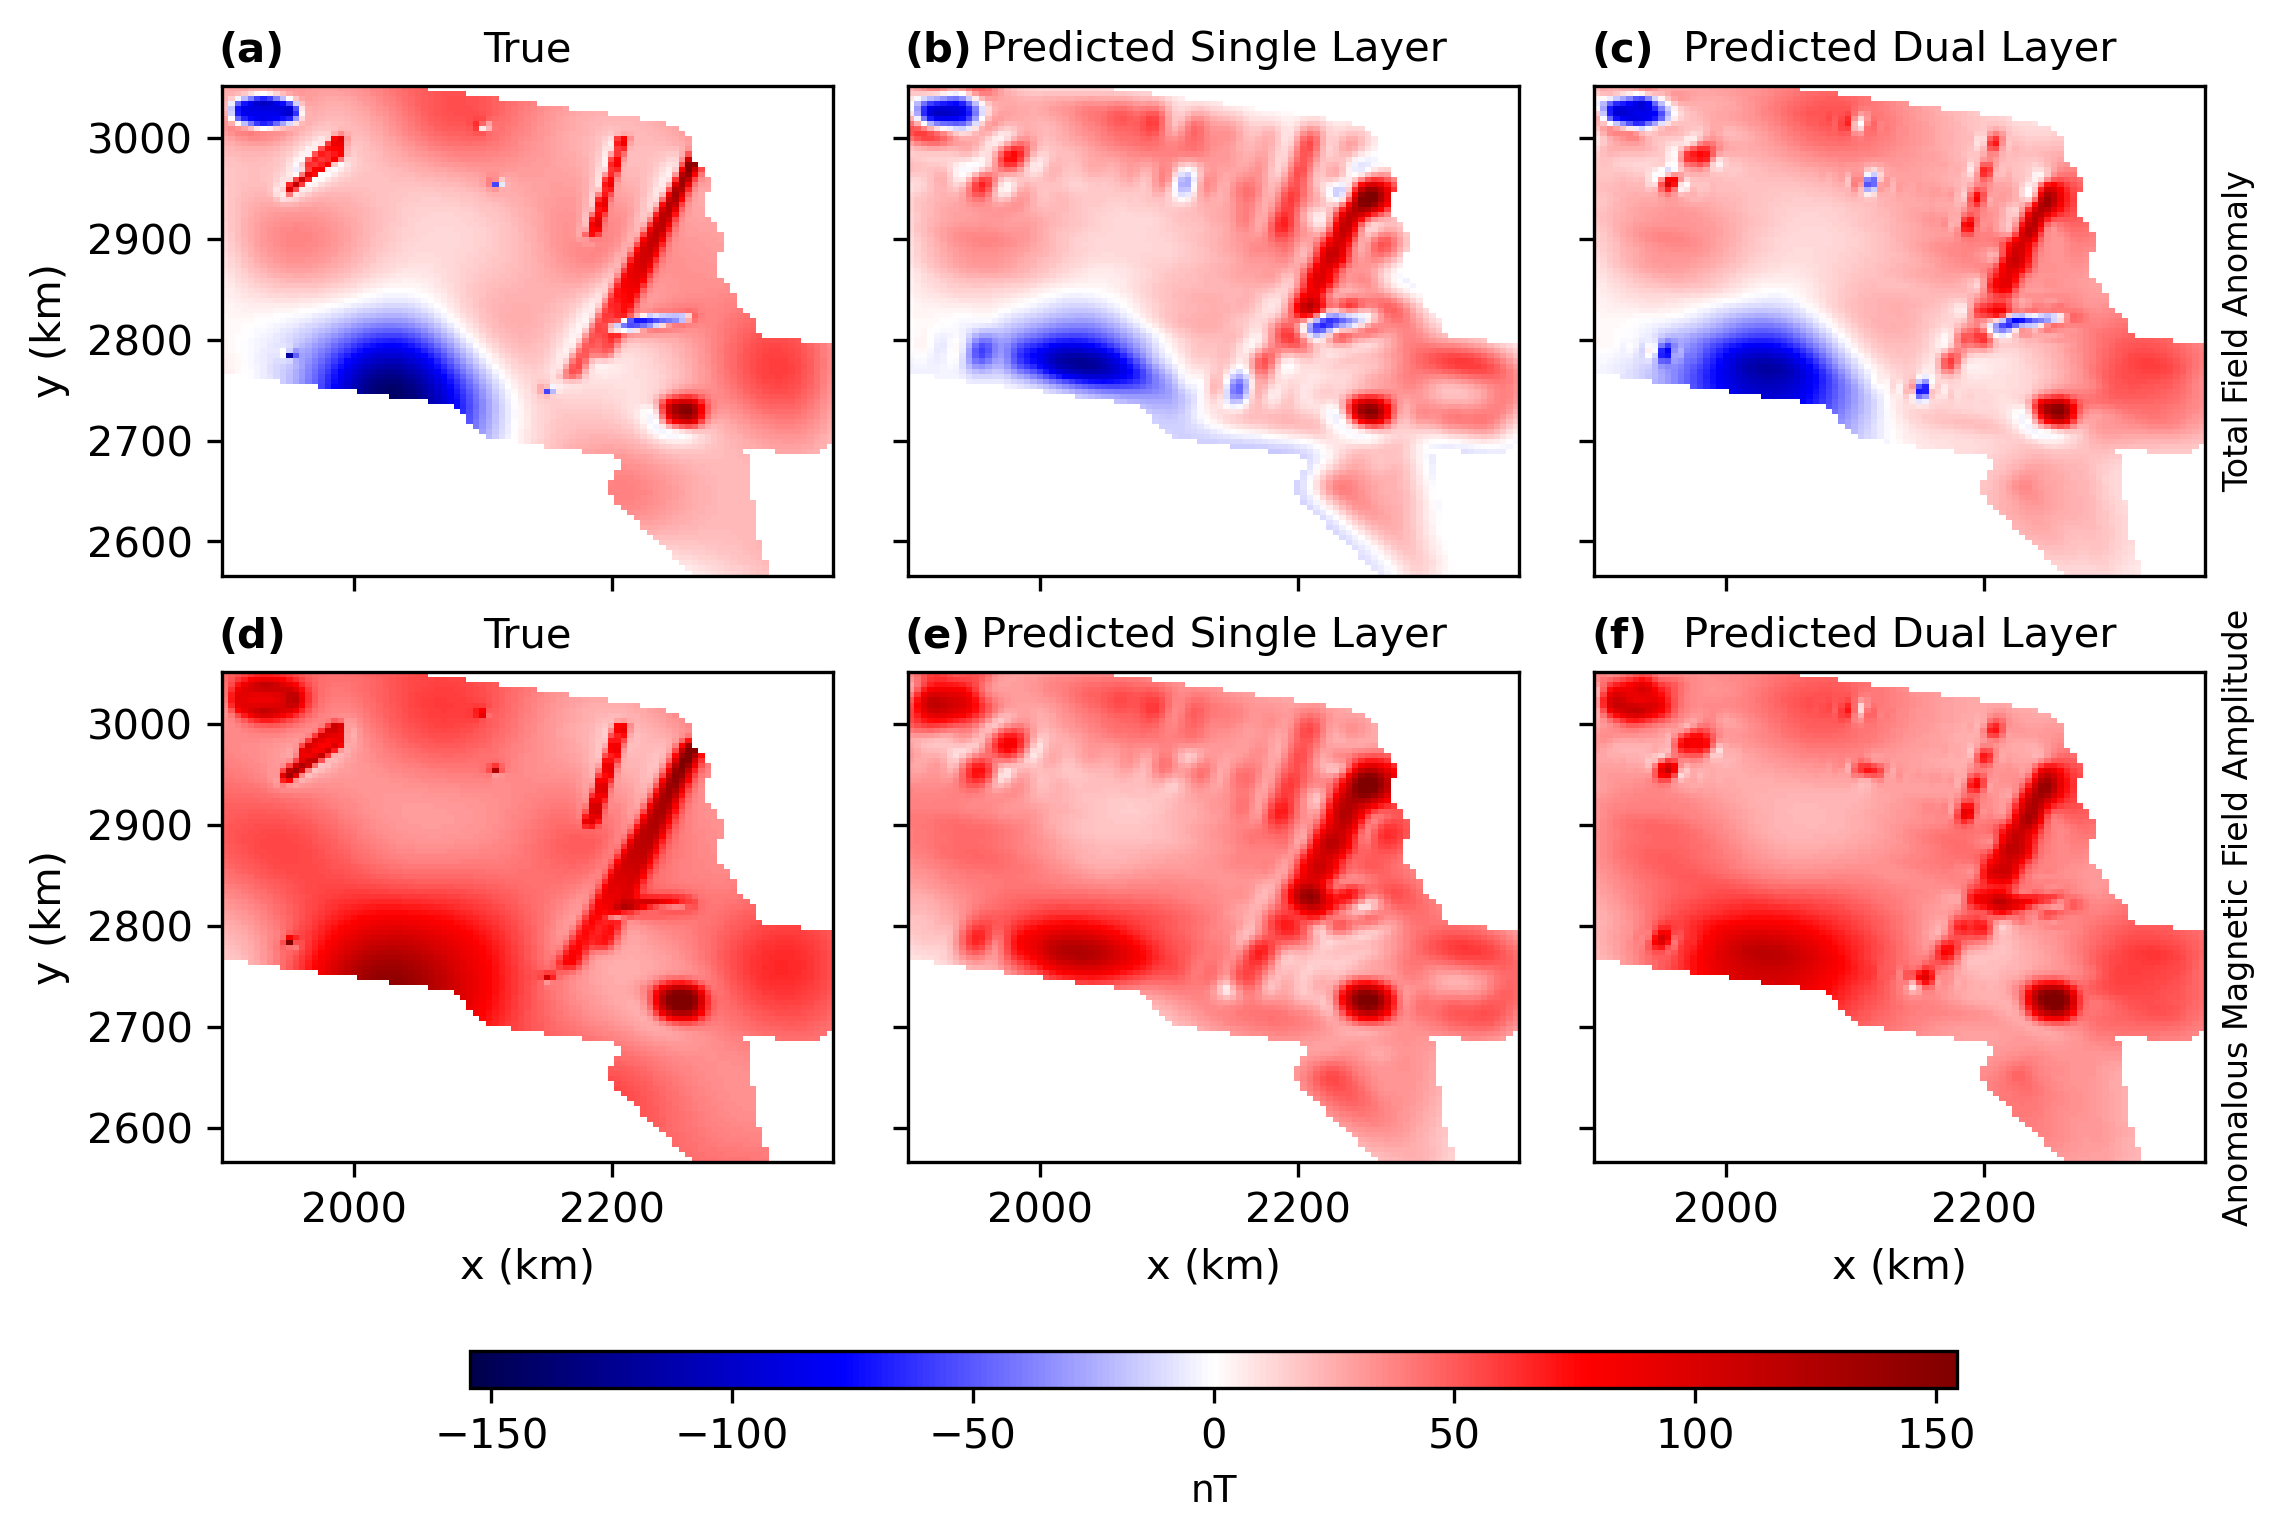

In [9]:
scale_tfa = vd.maxabs(true_tfa)

fig, axes = plt.subplots(2, 3, figsize=(7.5, 5), sharex=True, sharey=True, gridspec_kw={'wspace': 0.01}, layout="constrained")
plot1 = axes[0,0].pcolormesh(
    *grid_coordinates_km[:2],
    true_tfa_2800,
    cmap="seismic",
    vmin=-scale_tfa,
    vmax=scale_tfa,
)
axes[0,0].set_title("True", fontsize=10)
axes[0,0].set_ylabel("y (km)", fontsize=10)
axes[0,0].text(-0.005, 1.05, '(a)', transform=axes[0,0].transAxes, fontsize=10, fontweight='bold')

plot2 = axes[0,1].pcolormesh(
    *grid_coordinates_km[:2],
    predicted_tfa_grid_1layer_2800,
    cmap="seismic",
    vmin=-scale_tfa,
    vmax=scale_tfa,
)
axes[0,1].set_title("Predicted Single Layer", fontsize=10)
axes[0,1].text(-0.005, 1.05, '(b)', transform=axes[0,1].transAxes, fontsize=10, fontweight='bold')

plot3 = axes[0,2].pcolormesh(
    *grid_coordinates_km[:2],
    predicted_tfa_grid_2800,
    cmap="seismic",
    vmin=-scale_tfa,
    vmax=scale_tfa,
)
axes[0,2].set_title("Predicted Dual Layer", fontsize=10)
axes[0,2].set_ylabel("Total Field Anomaly", fontsize=8)
axes[0,2].yaxis.set_label_position('right')
axes[0,2].text(-0.005, 1.05, '(c)', transform=axes[0,2].transAxes, fontsize=10, fontweight='bold')

plot4 = axes[1,0].pcolormesh(
    *grid_coordinates_km[:2],
    true_bnorm_2800,
    cmap="seismic",
    vmin=-scale_tfa,
    vmax=scale_tfa
)
axes[1,0].set_title("True", fontsize=10)
axes[1,0].set_xlabel("x (km)", fontsize=10)
axes[1,0].set_ylabel("y (km)", fontsize=10)
axes[1,0].text(-0.005, 1.05, '(d)', transform=axes[1,0].transAxes, fontsize=10, fontweight='bold')

plot5 = axes[1,1].pcolormesh(
    *grid_coordinates_km[:2],
    predicted_bnorm_grid_1layer_2800,
    cmap="seismic",
    vmin=-scale_tfa,
    vmax=scale_tfa
)
axes[1,1].set_title("Predicted Single Layer", fontsize=10)
axes[1,1].set_xlabel("x (km)", fontsize=10)
axes[1,1].text(-0.005, 1.05, '(e)', transform=axes[1,1].transAxes, fontsize=10, fontweight='bold')

plot6 = axes[1,2].pcolormesh(
    *grid_coordinates_km[:2],
    predicted_bnorm_grid_2800,
    cmap="seismic",
    vmin=-scale_tfa,
    vmax=scale_tfa
)
axes[1,2].set_title("Predicted Dual Layer", fontsize=10)
axes[1,2].set_xlabel("x (km)", fontsize=10)
axes[1,2].set_ylabel("Anomalous Magnetic Field Amplitude", fontsize=8)
axes[1,2].yaxis.set_label_position('right')
axes[1,2].text(-0.005, 1.05, '(f)', transform=axes[1,2].transAxes, fontsize=10, fontweight='bold')

cbar = fig.colorbar(plot6, ax=fig.axes, orientation="horizontal", pad=0.05, shrink=0.75, aspect=40)
cbar.set_label("nT", fontsize=9)

# fig.show()
truncated_regional_figure = Path("..") / "paper" / "figures" / "truncated_regional.png"
fig.savefig(truncated_regional_figure, dpi=300, bbox_inches="tight")
plt.close()
Image(truncated_regional_figure)